<a href="https://colab.research.google.com/github/Yuliya1911/Study/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

##### 1. Скачать данные о рынке недвижимости c открытого соревнования Сбербанка по машинному обучению https://www.kaggle.com/c/sberbank-russian-housing-market/data. Скачиваем только файлы train.csv.zip, macro.csv.zip и сливаем  в один датафрейм. Описание колонок - data_dictionary.txt

In [ ]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor

from IPython.core.pylabtools import figsize

In [ ]:
# z_macro = zipfile.ZipFile("macro.csv.zip")
# z_train = zipfile.ZipFile("train.csv.zip")

z_macro = zipfile.ZipFile("/content/drive/MyDrive/sberbank-russian-housing-market/macro.csv.zip")
z_train = zipfile.ZipFile("/content/drive/MyDrive/sberbank-russian-housing-market/train.csv.zip")

In [ ]:
# Просмотр архивов для выбора нужных файлов

print('Файлы в архиве macro.csv -', z_macro.namelist())
print('Файлы в архиве train.csv -', z_train.namelist())

Файлы в архиве macro.csv - ['macro.csv']
Файлы в архиве train.csv - ['train.csv', '__MACOSX/', '__MACOSX/._train.csv']


In [ ]:
# Считываю и просматриваю датасет macro.csv

df_macro = pd.read_csv(z_macro.open("macro.csv"))
# df_macro.head()

In [ ]:
df_macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   timestamp                                   2484 non-null   object 
 1   oil_urals                                   2484 non-null   float64
 2   gdp_quart                                   2394 non-null   float64
 3   gdp_quart_growth                            2394 non-null   float64
 4   cpi                                         2453 non-null   float64
 5   ppi                                         2453 non-null   float64
 6   gdp_deflator                                2119 non-null   float64
 7   balance_trade                               2453 non-null   float64
 8   balance_trade_growth                        2394 non-null   float64
 9   usdrub                                      2481 non-null   float64
 10  eurrub     

In [ ]:
# Считываю и просматриваю датасет train.csv

df_train = pd.read_csv(z_train.open("train.csv"))
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [ ]:
df_macro['timestamp'] = pd.to_datetime(df_macro['timestamp'])
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

Решила проверить влияние расположения квартиры на стоимость за 1 кв. метр, сгрупппировав квартиры по административным округам. Для этого создала отдельный файл с данными по принадлежности районов к округам и его использую в дальнейших операциях (приложен в папку с курсовой работой)

In [ ]:
# Считываю и просматриваю датасет area_m.csv

area_moskva = pd.read_csv("area_m.csv", sep=";")
area_moskva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sub_area  146 non-null    object
 1   area      146 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [ ]:
# Склеиваю датасеты с помощью метода merge по столбцу 'timestamp'. Основным беру датафрейм df_train

df = df_train.merge(df_macro, on = 'timestamp', how = 'left')
df = df.merge(area_moskva, on = 'sub_area', how = 'left')
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 0 to 30470
Data columns (total 392 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   id                                          int64         
 1   timestamp                                   datetime64[ns]
 2   full_sq                                     int64         
 3   life_sq                                     float64       
 4   floor                                       float64       
 5   max_floor                                   float64       
 6   material                                    float64       
 7   build_year                                  float64       
 8   num_room                                    float64       
 9   kitch_sq                                    float64       
 10  state                                       float64       
 11  product_type                                object   

In [ ]:
# Проверяю корректность объединения файлов

print('Датафрейм', 'Строк', 'Столбцов')
print('Macro  - ', df_macro.shape)
print('Train  - ', df_train.shape)
print('df     - ', df.shape)

Датафрейм Строк Столбцов
Macro  -  (2484, 100)
Train  -  (30471, 292)
df     -  (30471, 392)


In [ ]:
# Описательная статистика для числовых столбцов датасета

df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,...,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,load_of_teachers_school_per_teacher,students_state_oneshift,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,23783.000000,30471.000000,30471.000000,23786.000000,30471.000000,30471.000000,16030.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,...,27232.000000,27232.000000,27232.000000,27232.000000,27232.000000,27232.000000,27232.000000,27232.000000,27232.000000,30471.000000,27232.000000,27232.000000,27232.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,13570.000000,30471.000000,30471.000000,27232.000000,30471.000000,30471.000000,27232.000000,27232.000000,27232.000000,5592.000000,753.0,30471.000000,13570.000000,30471.000000,13570.000000,30471.000000,27232.000000,13570.000000,27232.000000,30471.000000
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,1.765705e+07,84056.425552,0.218922,0.118871,5140.026156,3271.272464,4.065111,5354.269699,8324.970739,4.705031,0.109678,1190.738677,1.320895,0.138295,6.635030,2.896393,0.286732,4.200978,8.253454,1.463062e+05,67207.789603,79098.662105,11178.809491,5723.853106,5455.013948,53667.908897,27253.585803,26414.414821,19209.707164,5811.618162,...,19.207997,98.830416,98.633182,98.091646,43.546636,94.356481,54.802225,99.316591,0.397235,76.446097,6.897602,8.367203,676.626245,163.273194,97.540425,75.393854,56.615071,49.038418,41.012331,32.638114,857.129875,1489.569760,92.885492,63.272187,94.678327,8068.826331,94.663877,752.808901,290.625514,786.863197,271.0,9744.564143,615.001326,0.447397,1382.187988,366627.117423,26.677108,72.552108,44910.638807,229594.127331
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,2.064961e+07,57871.285899,0.175090,0.118688,3816.625140,2169.759592,2.993795,3989.640917,4289.734174,3.445105,0.333328,1057.015001,1.492903,0.443796,6.571982,3.290058,1.510491,4.741812,23.536953,2.830251e+05,129444.557322,153630.894568,8287.957623,4275.438364,4020.546283,37483.559701,18939.154637,18643.132758,13174.721197,4073.828409,...,0.082854,0.180372,0.196770,0.242560,0.298697,0.229750,0.447910,0.098385,0.016397,0.362479,0.856788,1.080391,15.700671,20.473868,9.540300,6.942476,5.845139,2.220075

In [ ]:
# Описательная статистика для категориальных столбцов датасета

df.describe(include = ['object']).T

,count,unique,top,freq
product_type,30471,2,Investment,19448
sub_area,30471,146,Poselenie Sosenskoe,1776
culture_objects_top_25,30471,2,no,28543
thermal_power_plant_raion,30471,2,no,28817
incineration_raion,30471,2,no,28155
oil_chemistry_raion,30471,2,no,30175
radiation_raion,30471,2,no,19600
railroad_terminal_raion,30471,2,no,29335
big_market_raion,30471,2,no,27649
nuclear_reactor_raion,30471,2,no,29608


##### 2. Провести чистку данных (пропуски данных, неинформативные признаки, аномалии, оцифровка текстовых столбцов и т.п.)

На мой взгляд самыми важными критериями при выборе квартиры являются следующие признаки (по крайней мере свою квартиру мы именно по данным признакам и выбирали):
- площадь
- год постройки
- этажность дома и этаж расположения квартиры
- район
- стоимость за квадрат
- и количество комнат

##### 2.1 Чистка данных с помощью процентного списка пропущенных данных

In [ ]:
print('Количество строк, столбцов в датафрейме - ', df.shape)

Количество строк, столбцов в датафрейме -  (30471, 392)


In [ ]:
# Вывожу список столбцов с пропусками данных больше 50% (чтобы не удалить ничего лишнего).

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing > 0.5:
      print('{} - {}%'.format(col, round(pct_missing*100)))

load_of_teachers_preschool_per_teacher - 55%
provision_retail_space_sqm - 82%
provision_retail_space_modern_sqm - 98%
theaters_viewers_per_1000_cap - 55%
museum_visitis_per_100_cap - 55%
students_reg_sports_share - 55%


Вывод: из всех представленных недозаполнненых столбцов на мой взгляд ни один из них не является критичным при выборе квартиры. Тем более в условиях текущего состояния экономики - все быстро меняется. Также данные столбцы будут зачимыми только для узкого круга лиц. Поэтому удаляю все 6-ть столбцов.

In [ ]:
# Удаление столбцов с пропусками

for col in df.columns:
  if np.mean(df[col].isnull()) > 0.5:
    df = df.drop(col, axis=1)
    
print('Количество строк, столбцов в датафрейме - ', df.shape)

Количество строк, столбцов в датафрейме -  (30471, 386)


##### 2.2 Обработка категориальных признаков

In [ ]:
# Вывод всех столбцов с типом 'object'

a = df.loc[:, df.dtypes == np.object]
a.head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,child_on_acc_pre_school,modern_education_share,old_education_build_share,area
0,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good,#!,NaN,NaN,СВАО
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent,#!,NaN,NaN,ЮАО
2,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor,#!,NaN,NaN,ЮВАО
3,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good,#!,NaN,NaN,СЗАО
4,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent,#!,NaN,NaN,ЦАО


In [ ]:
# Получаю список столбцов с типом 'object'

a.columns.tolist()

['product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology',
 'child_on_acc_pre_school',
 'modern_education_share',
 'old_education_build_share',
 'area']

In [ ]:
# Перекодировка названия событий в 0/1 с помощью лямбда-функции

for col in df[['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line']]:
  df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)

##### 2.3 Преобразование текстовых столбцов к числовому типу

In [ ]:
# Вывод оставшихся столбцов с типом 'object'

df.loc[:, df.dtypes == np.object]

,product_type,sub_area,ecology,child_on_acc_pre_school,modern_education_share,old_education_build_share,area
0,Investment,Bibirevo,good,#!,NaN,NaN,СВАО
1,Investment,Nagatinskij Zaton,excellent,#!,NaN,NaN,ЮАО
2,Investment,Tekstil'shhiki,poor,#!,NaN,NaN,ЮВАО
3,Investment,Mitino,good,#!,NaN,NaN,СЗАО
4,Investment,Basmannoe,excellent,#!,NaN,NaN,ЦАО
...,...,...,...,...,...,...,...
30466,Investment,Otradnoe,good,NaN,"95,4918","8,2517",СВАО
30467,Investment,Tverskoe,poor,NaN,"95,4918","8,2517",ЦАО
30468,OwnerOccupier,Poselenie Vnukovskoe,no data,NaN,"95,4918","8,2517",НАО
30469,Investment,Obruchevskoe,satisfactory,NaN,"95,4918","8,2517",ЮЗАО


In [ ]:
for elem in df[['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share', 'product_type', 'ecology']]:
  print("Столбец '" + df[elem].name + "' содержит следующие значения - ", df[elem].unique())

Столбец 'child_on_acc_pre_school' содержит следующие значения -  ['#!' '7,311' '3,013' '16,765' nan]
Столбец 'modern_education_share' содержит следующие значения -  [nan '90,92' '93,08' '95,4918']
Столбец 'old_education_build_share' содержит следующие значения -  [nan '23,14' '25,47' '8,2517']
Столбец 'product_type' содержит следующие значения -  ['Investment' 'OwnerOccupier']
Столбец 'ecology' содержит следующие значения -  ['good' 'excellent' 'poor' 'satisfactory' 'no data']


In [ ]:
# Замена некорректных символов '#!'

df['child_on_acc_pre_school'] = df['child_on_acc_pre_school'].replace('#!', np.nan)

In [ ]:
# Замена некорректных символов ','

list1 = ['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']
for col in list1:
  df[col] = df[col].str.replace(',', '.').astype(float)

##### 2.4 Преобразование порядкового категориального столбца

In [ ]:
dict_ecology = {'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4, 'no_data': np.nan}
df['ecology'] = df['ecology'].map(dict_ecology)

In [ ]:
dict_product_type = {'Investment': 1, 'OwnerOccupier': 2}
df['product_type'] = df['product_type'].map(dict_product_type)

In [ ]:
dict_area = {'НАО': 1, 'ЮВАО': 2, 'ЮАО': 3, 'ВАО': 4, 'ЮЗАО': 5, 'САО': 6, 'СВАО': 7, 'ЗАО': 8, 'СЗАО': 9, 'ЦАО': 10, 'ЗелАО': 11, 'ТАО': 12}
df['area'] = df['area'].map(dict_area)

In [ ]:
sub_area = (df['sub_area'].value_counts() >= 100).loc[lambda x: x == True].index.tolist()
df['sub_area_new'] = np.where(df['sub_area'].isin(sub_area), df['sub_area'], 'Other')
df = df.drop('sub_area', axis=1)
df['sub_area_new'].value_counts()

Other                   1851
Poselenie Sosenskoe     1776
Nekrasovka              1611
Poselenie Vnukovskoe    1372
Poselenie Moskovskij     925
                        ... 
Krylatskoe               103
Butyrskoe                101
Prospekt Vernadskogo     100
Silino                   100
Alekseevskoe             100
Name: sub_area_new, Length: 109, dtype: int64

In [ ]:
df['state'].value_counts()

2.0     5844
3.0     5790
1.0     4855
4.0      422
33.0       1
Name: state, dtype: int64

In [ ]:
df['state'].replace(33, 3, inplace=True)

##### 2.5 Удаление неинформативных признаков и дубликатов

In [ ]:
df = df.drop(['id', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal','ID_metro', 'ID_railroad_station_avto', 
              'ID_railroad_station_walk', 'ID_railroad_terminal'], axis=1)
df.shape

(30471, 378)

In [ ]:
print('Количество дубликатов - ', df.duplicated().sum())

df = df.drop_duplicates()
print('Количество строк, столбцов в датафрейме - ', df.shape)

Количество дубликатов -  10
Количество строк, столбцов в датафрейме -  (30461, 378)


##### 2.6 Обработка столбцов 'fill_sq', 'life_sq', 'kitch_sq'

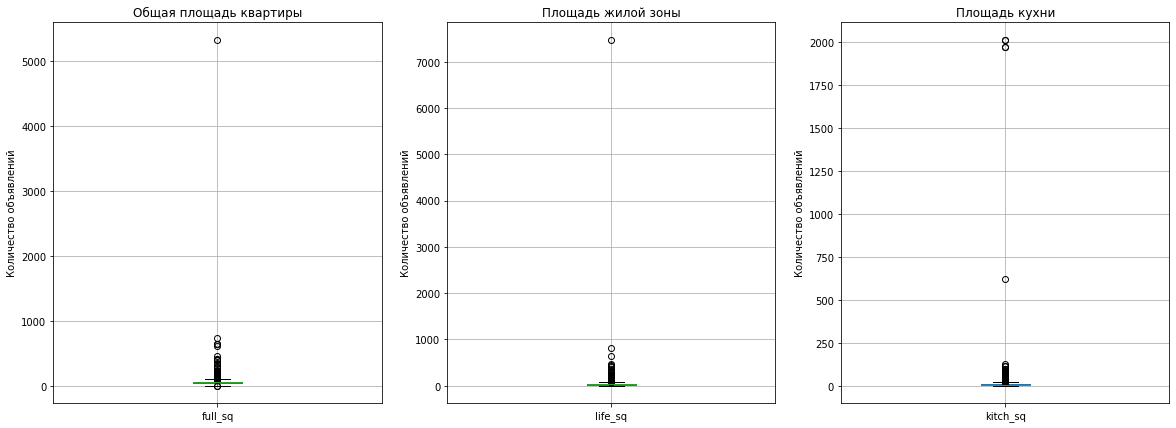

In [ ]:
# Оценка выбросов значений площадей
 
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
df.boxplot(column=['full_sq'])

plt.title('Общая площадь квартиры')
plt.ylabel('Количество объявлений');

plt.subplot(1,3,2)
df.boxplot(column=['life_sq'])

plt.title('Площадь жилой зоны')
plt.ylabel('Количество объявлений');

plt.subplot(1,3,3)
df.boxplot(column=['kitch_sq'])

plt.title('Площадь кухни')
plt.ylabel('Количество объявлений');

Для заполнения и корректировки площадей квартир, провожу расчет коэффицинтов:
- отношение жилой площади к общей площади
- отношение площади кухни к общей площади

In [ ]:
df[['full_sq', 'life_sq', 'kitch_sq']].describe()

,full_sq,life_sq,kitch_sq
count,30461.000000,24085.000000,20894.000000
mean,54.211877,34.399128,6.398535
std,38.034562,52.285018,28.268262
min,0.000000,0.000000,0.000000
25%,38.000000,20.000000,1.000000
50%,49.000000,30.000000,6.000000
75%,63.000000,43.000000,9.000000
max,5326.000000,7478.000000,2014.000000


In [ ]:
# Отфильтровываю все квартиры с площадями меньше 0.

kof = df[(df['full_sq'] > 0) & (df['life_sq'] > 0) & (df['kitch_sq'] > 0)]

# Согласно ГОСТам на строительство: минимальная площадь кухни - 4,5 кв.м.; минимальная площадь квартиры (однокомнатной) - 28 кв.м.; минимальная жилая площадь квартиры (однокомнатной) - 8 кв.м.
# Отфильтровываю все квартиры не подходящие под данные параметры

kof = kof[(kof['kitch_sq'] >= 4.5) & (kof['full_sq'] >= 28) & (kof['life_sq'] >= 8)]

# Отфильтровываю все квартиры, у которых суммарная площадь кухни и жилой зоны больше общей площади квартиры

kof = kof[(kof['full_sq'] > (kof['life_sq'] + kof['kitch_sq']))]

# Провожу расчет жилой площади к общей площади и кухни к общей площади:

print('Медиана соотношения жилой площади к общей площади квартиры - ', round((kof['life_sq'] / kof['full_sq']).median(), 2))
print('Медиана соотношения площади кухни к общей площади квартиры - ', round((kof['kitch_sq'] / kof['full_sq']).median(), 2))

print('Расчет произведен на выборке из', kof.shape[0], 'строк')

Медиана соотношения жилой площади к общей площади квартиры -  0.59
Медиана соотношения площади кухни к общей площади квартиры -  0.15
Расчет произведен на выборке из 13390 строк


In [ ]:
# Заполняю данные. Принимаю, что значение общей площади указано корректно. Расчеты веду исходя из рассчитанных коэффициентов и общей площади

df['life_sq'] = np.where(df['life_sq'].isna(), df['full_sq'] * 0.59, df['life_sq'])
df['life_sq'] = np.where(df['life_sq'] < 8, df['full_sq'] * 0.59, df['life_sq'])

df['kitch_sq'] = np.where(df['kitch_sq'].isna(), df['full_sq'] * 0.15, df['kitch_sq'])
df['kitch_sq'] = np.where(df['kitch_sq'] < 4.5, df['full_sq'] * 0.15, df['kitch_sq'])

df['full_sq'] = np.where(df['full_sq'] == 0, df['life_sq'] + df['kitch_sq'], df['full_sq'])

df[['full_sq', 'life_sq', 'kitch_sq']].describe()

,full_sq,life_sq,kitch_sq
count,30461.000000,30461.000000,30461.000000
mean,54.214405,34.909160,8.560405
std,38.033518,46.802759,23.804109
min,0.000000,0.000000,0.000000
25%,38.000000,21.830000,6.000000
50%,49.000000,30.090000,8.000000
75%,63.000000,43.000000,9.750000
max,5326.000000,7478.000000,2014.000000


In [ ]:
# Квартиру с нулевой квадратурой исключаю из выборки, поскольку это единичный случай

print('Количество строк в нулевой квадратурой - ', (df['full_sq'] == 0).sum())
df = df.drop(df[df['full_sq'] == 0].index)
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])

Количество строк в нулевой квадратурой -  1
Общее количество оставшихся строк в датафрейме -  30460


In [ ]:
full_sq02 = df['full_sq'].quantile(0.02)
full_sq98 = df['full_sq'].quantile(0.98)

print('Площадь квартир у 2% выбоки - {} кв.м.'.format(full_sq02))
print('Площадь квартир у 98% выбоки - {} кв.м.'.format(full_sq98))

Площадь квартир у 2% выбоки - 29.0 кв.м.
Площадь квартир у 98% выбоки - 112.0 кв.м.


In [ ]:
# Исключение из выборки квартир с общей площадью меньше 29 кв.м. и больше 112 кв.м.

df = df[df['full_sq'].between(full_sq02, full_sq98)]
df[['full_sq', 'life_sq', 'kitch_sq']].describe()

,full_sq,life_sq,kitch_sq
count,29379.000000,29379.000000,29379.000000
mean,52.636781,33.957429,8.368278
std,16.854666,46.300715,23.679132
min,29.000000,8.000000,0.000000
25%,39.000000,22.000000,6.000000
50%,49.000000,30.000000,8.000000
75%,63.000000,42.000000,9.600000
max,112.000000,7478.000000,2014.000000


In [ ]:
# Корректировка значений жилой площади и площади кухни (исходя из медианы соотношения площадей)

df['life_sq'] = np.where(df['life_sq'] >= df['full_sq'], df['full_sq'] * 0.59, df['life_sq'])
df['kitch_sq'] = np.where(df['kitch_sq'] >= df['full_sq'], df['full_sq'] * 0.15, df['kitch_sq'])

df['kitch_sq'] = np.where(df['kitch_sq'] >= df['life_sq'], df['full_sq'] * 0.15, df['kitch_sq'])

df[['full_sq', 'life_sq', 'kitch_sq']].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,full_sq,life_sq,kitch_sq
count,29379.000000,29379.000000,29379.000000
mean,52.636781,31.555462,7.980505
std,16.854666,11.863115,2.466320
min,29.000000,8.000000,0.000000
25%,39.000000,21.830000,6.000000
50%,49.000000,30.000000,8.000000
75%,63.000000,38.350000,9.600000
max,112.000000,101.000000,34.000000


In [ ]:
# Проверяю квартиру с 0 кв.м. кухни и вношу правки

df[(df['kitch_sq'] == 0)]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm,area,sub_area_new
24296,2014-11-05,77.0,45.43,4.0,17.0,1.0,0.0,3.0,0.0,1.0,2,25536296.81,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,17790,...,234.0,19.185045,98.8,98.6,98.1,43.3,94.3,55.2,99.3,0.4,76.7,6.1,7.61,662.3,162.0,101.75,83.47,61.88,53.21,43.23,34.3,16.765,1517.954545,85.5056,93.08,25.47,61.0,92.8,7804.909725,41.9,707.0,286.0,10311.0,0.44784,398451.0,28.2,46080.0,229294.8,1,Poselenie Vnukovskoe


In [ ]:
df['kitch_sq'] = np.where(df['kitch_sq'] < 4.5, df['full_sq'] * 0.15, df['kitch_sq'])
df[['full_sq', 'life_sq', 'kitch_sq']].describe()

,full_sq,life_sq,kitch_sq
count,29379.000000,29379.000000,29379.000000
mean,52.636781,31.555462,7.980898
std,16.854666,11.863115,2.465968
min,29.000000,8.000000,4.350000
25%,39.000000,21.830000,6.000000
50%,49.000000,30.000000,8.000000
75%,63.000000,38.350000,9.600000
max,112.000000,101.000000,34.000000


In [ ]:
# Проверяю квартиры, у которых общая площадь меньше суммарной площади кухни и жилой площади. 

print('Количество квартир, у которых общая площадь меньше суммарной площади кухни и жилой площади:', (df['full_sq'] < (df['life_sq'] + df['kitch_sq'])).sum())

# Вношу правки в жилую площадь и площадь кухни исходя из рассчитанных коэффициентов

df['life_sq'] = np.where(df['full_sq'] < (df['life_sq'] + df['kitch_sq']), df['full_sq'] * 0.59, df['life_sq'])
df['kitch_sq'] = np.where(df['full_sq'] < (df['life_sq'] + df['kitch_sq']), df['full_sq'] * 0.15, df['kitch_sq'])

print('Проверка. Количество квартир, у которых общая площадь меньше суммарной площади кухни и жилой площади:', (df['full_sq'] < (df['life_sq'] + df['kitch_sq'])).sum())

Количество квартир, у которых общая площадь меньше суммарной площади кухни и жилой площади: 1024
Проверка. Количество квартир, у которых общая площадь меньше суммарной площади кухни и жилой площади: 0


In [ ]:
print('Количество оставшихся строк, столбцов в датафрейме - ', df.shape)

Количество оставшихся строк, столбцов в датафрейме -  (29379, 378)


##### 2.7 Обработка стоблца 'num_room'

In [ ]:
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])
print('Количество строк в пустым количеством комнат (NaN) - ', df['num_room'].isna().sum())
print('Количество строк в заполненным количеством комнат - ', df['num_room'].count())

Общее количество оставшихся строк в датафрейме -  29379
Количество строк в пустым количеством комнат (NaN) -  9178
Количество строк в заполненным количеством комнат -  20201


In [ ]:
# Согласно ГОСТ минимальная жилая площадь 2-х комнатной квартиры должна составлять не менее 22 кв.м. 
# Поэтому все квартиры, у которых не указано количество комнат и жилая площадь меньше 22 кв.м. - считаем однушками

df['num_room'] = np.where(df['num_room'].isna() & (df['life_sq'] < 22), 1, df['num_room'])

In [ ]:
# Согласно ГОСТ минимальная жилая площадь 3-х комнатной квартиры должна составлять не менее 30 кв.м. 
# Поэтому все квартиры, у которых не указано количество комнат и жилая площадь меньше 30 кв.м. - считаем двушками

df['num_room'] = np.where(df['num_room'].isna() & (df['life_sq'] < 30), 2, df['num_room'])

In [ ]:
# Согласно ГОСТ минимальная жилая площадь 4-х комнатной квартиры должна составлять не менее 40 кв.м. 
# Поэтому все квартиры, у которых не указано количество комнат и жилая площадь меньше 40 кв.м. - считаем трешками

df['num_room'] = np.where(df['num_room'].isna() & (df['life_sq'] < 40), 3, df['num_room'])

In [ ]:
# Так как квартиры с количеством комнат больше 4х непопулярны и информации по ним достаточно мало (и разброс по квадратуре очень большой), 
# исключаю их из выборки

df = df.drop(df[df['num_room'] > 4].index)

# Также исключаю квартиры с незаполннеными данными по количеству комнат и 0 количеством комнат

df = df.drop(df[df['num_room'] == 0].index)
df = df.drop(df[df['num_room'].isna()].index)
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])

Общее количество оставшихся строк в датафрейме -  27494


##### 2.8 Расчет стоимости 1 метра квадратного

In [ ]:
# фичи со временем

df['dow'] = df['timestamp'].dt.dayofweek
df['dom'] = df['timestamp'].dt.day
df['doy'] = df['timestamp'].dt.dayofyear
df['month'] = df['timestamp'].dt.month
df['woy'] = df['timestamp'].dt.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [ ]:
df.shape

(27494, 383)

In [ ]:
##### Расчет стоимости 1 кв.м.

df['price_per_sq'] = df['price_doc'] / df['full_sq']

##### Расчет target аналогично примеру в лекции

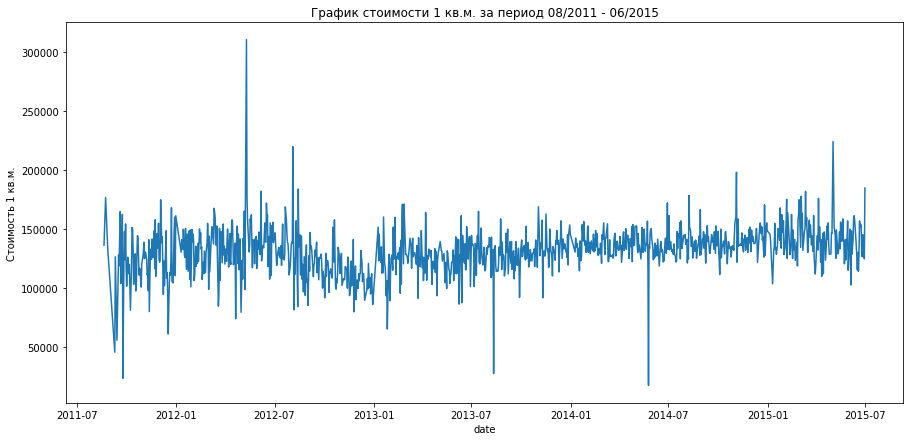

In [ ]:
df_lec = df

df_lec['date'] = df_lec['timestamp'].dt.date
agg1 = df_lec.groupby('date')['price_per_sq'].mean()
plt.figure(figsize=(15,7))
plt.title('График стоимости 1 кв.м. за период 08/2011 - 06/2015')
plt.xlabel('Дата')
plt.ylabel('Стоимость 1 кв.м.')
agg1.plot();

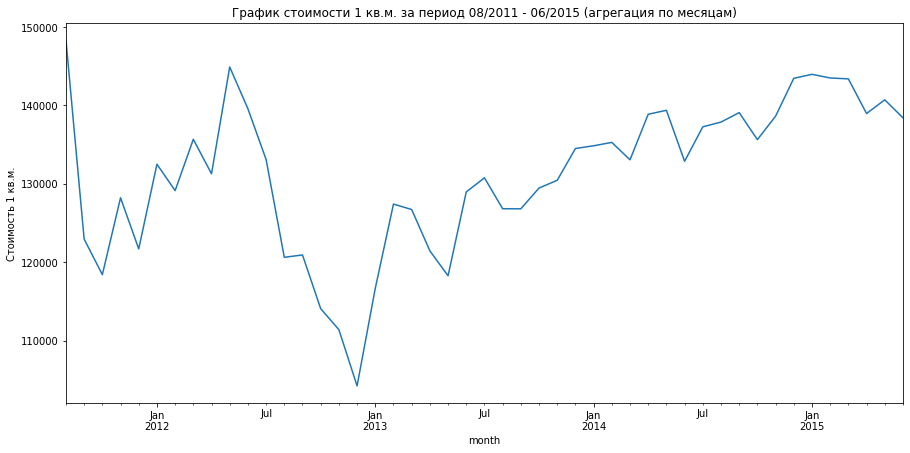

In [ ]:
df_lec['month'] = df_lec['timestamp'].dt.to_period('M')
agg2 = df_lec.groupby('month')['price_per_sq'].mean()
plt.figure(figsize=(15,7))
plt.title('График стоимости 1 кв.м. за период 08/2011 - 06/2015 (агрегация по месяцам)')
plt.xlabel('Дата')
plt.ylabel('Стоимость 1 кв.м.')
agg2.plot();

In [ ]:
# "Очистка" стоимости кв.м. от инфляции

price_index = agg2 / agg2[-1]
price_index

month
2011-08    1.071763
2011-09    0.888175
2011-10    0.855382
2011-11    0.926249
2011-12    0.879109
2012-01    0.957221
2012-02    0.932868
2012-03    0.980187
2012-04    0.948399
2012-05    1.046888
2012-06    1.008355
2012-07    0.961539
2012-08    0.871376
2012-09    0.873538
2012-10    0.824016
2012-11    0.804648
2012-12    0.752798
2013-01    0.842766
2013-02    0.920445
2013-03    0.915448
2013-04    0.877357
2013-05    0.854327
2013-06    0.931648
2013-07    0.944663
2013-08    0.916141
2013-09    0.916095
2013-10    0.935249
2013-11    0.942390
2013-12    0.971673
2014-01    0.974205
2014-02    0.977321
2014-03    0.961256
2014-04    1.003272
2014-05    1.006908
2014-06    0.959887
2014-07    0.991672
2014-08    0.996059
2014-09    1.004794
2014-10    0.979894
2014-11    1.001489
2014-12    1.036401
2015-01    1.040096
2015-02    1.036719
2015-03    1.035906
2015-04    1.003961
2015-05    1.016576
2015-06    1.000000
Freq: M, Name: price_per_sq, dtype: float64

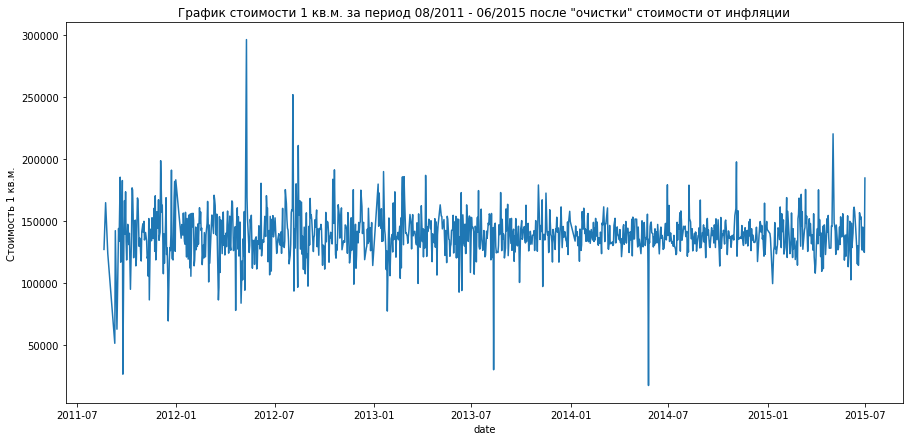

In [ ]:
dict3 = price_index.to_dict()
df_lec['price_index'] = df_lec['month'].map(dict3)
df_lec['price_per_sq_const'] = df_lec['price_per_sq'] / df_lec['price_index']
agg3 = df_lec.groupby('date')['price_per_sq_const'].mean()
plt.figure(figsize=(15,7))
plt.title('График стоимости 1 кв.м. за период 08/2011 - 06/2015 после "очистки" стоимости от инфляции')
plt.xlabel('Дата')
plt.ylabel('Стоимость 1 кв.м.')
agg3.plot();

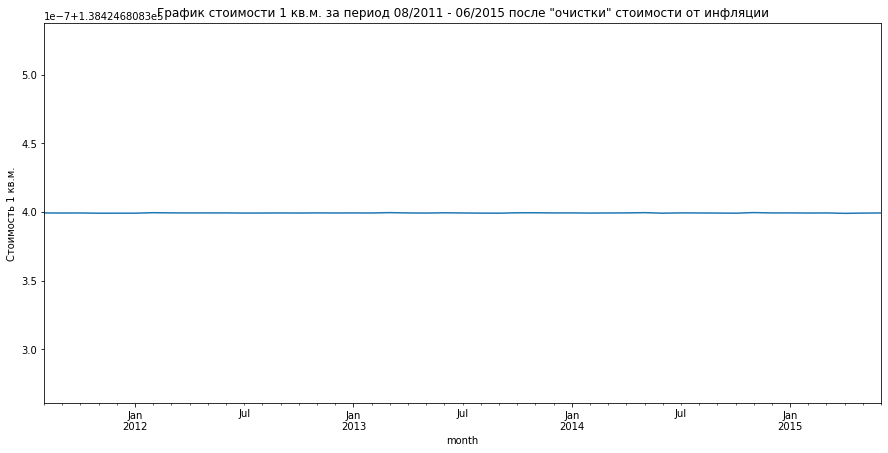

In [ ]:
agg4 = df_lec.groupby('month')['price_per_sq_const'].mean()
plt.figure(figsize=(15,7))
plt.title('График стоимости 1 кв.м. за период 08/2011 - 06/2015 после "очистки" стоимости от инфляции')
plt.xlabel('Дата')
plt.ylabel('Стоимость 1 кв.м.')
agg4.plot();

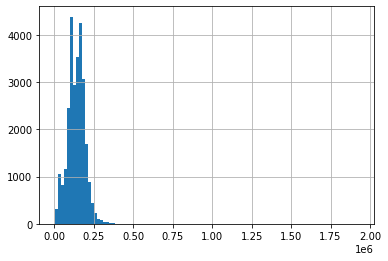

In [ ]:
df_lec['price_per_sq_const'].hist(bins = 100);

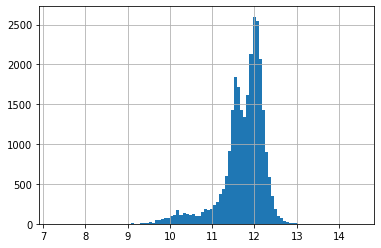

In [ ]:
np.log1p(df_lec['price_per_sq_const']).hist(bins = 100);

In [ ]:
df_lec['target'] = np.log1p(df_lec['price_per_sq_const'])

In [ ]:
df_lec['target'].describe()

count    27494.000000
mean        11.734075
std          0.512833
min          7.277890
25%         11.535851
50%         11.854545
75%         12.065387
max         14.472887
Name: target, dtype: float64

##### Я решила проверить зависимость стоимости квадратного метра от района расположения квартиры. Для этого предварительно укрупнила районы по административным округам. 

**В лекции target рассчитывался для общей выборки в целом. Так как стоимость квадратного метра разнится в зависимости от района расположения - провожу расчет terget для каждого округа**

In [ ]:
def grafik_price(number_area):

  #делаем новый DF с данными по одному округу
  okrug = df.loc[df['area'] == number_area]

  #преобразуем дату, делаем отдельно месяц
  okrug.loc[:,'month'] = okrug['timestamp'].dt.to_period('M')

  #рассчитываем среднее значение по цене за м2
  price_per_sq_okrug_m = okrug.groupby('month')['price_per_sq'].mean()

  #строим графики для визуального анализа
  plt.figure(figsize=(15,7))
  plt.title(f'График стоимости 1 кв.м. за период 08/2011 - 06/2015 для АО - {number_area}')
  price_per_sq_okrug_m.plot()

  #рассчитываем разницу между текущим и предыдущим месяцем
  price_index_okrug_m = price_per_sq_okrug_m / price_per_sq_okrug_m[-1]

  #преобразуем рассчитанные значения в Dictionary, чтобы записать их в основной DF
  dict_infl_okrug_m = price_index_okrug_m.to_dict()

  #TODO:записывать значения нужно только по определенному округу
  df.loc[df['area'] == number_area, 'price_index'] = okrug.loc[df['area'] == number_area, 'month'].map(dict_infl_okrug_m)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

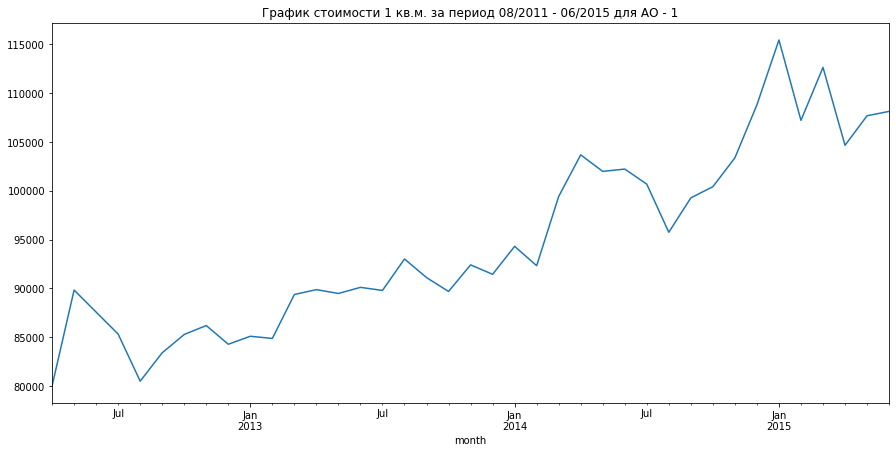

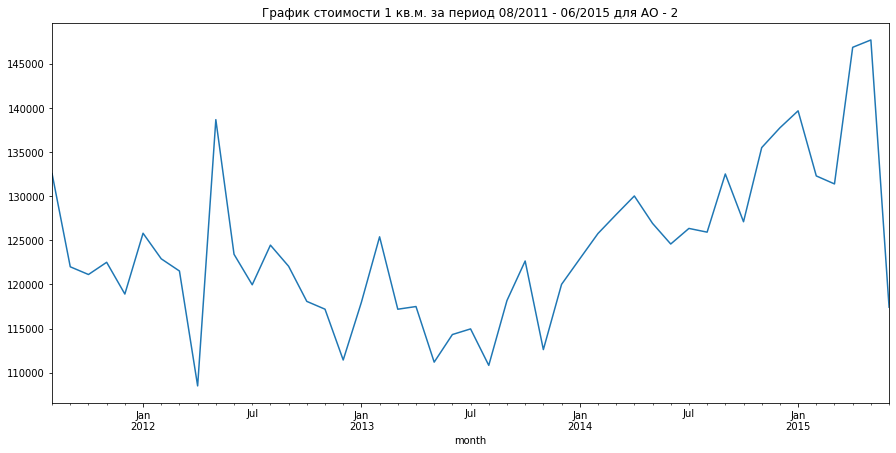

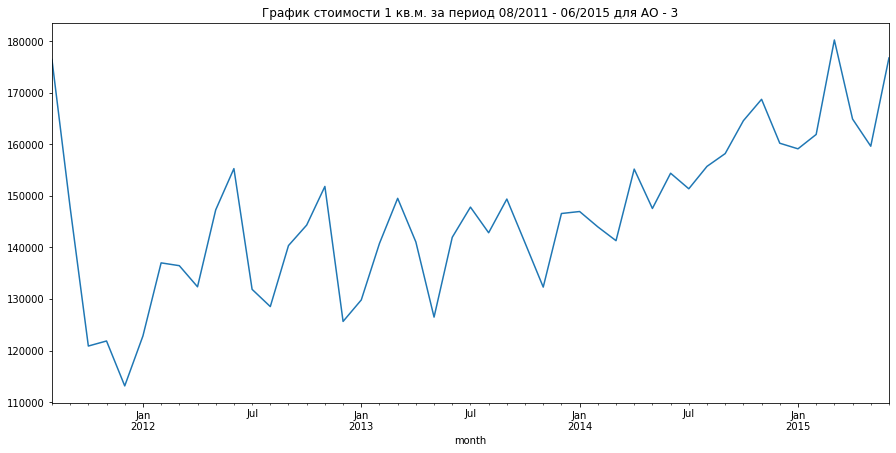

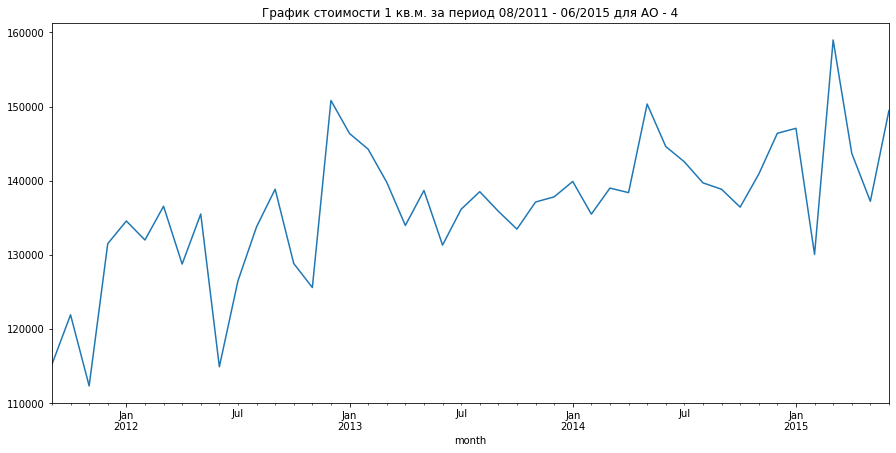

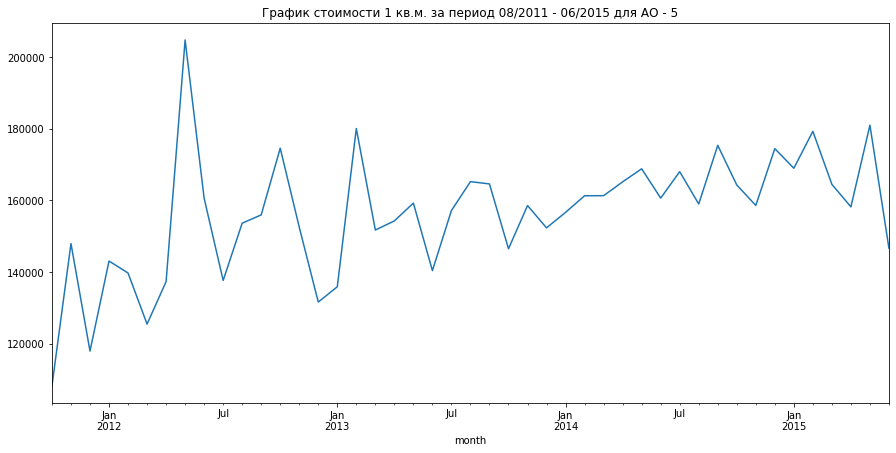

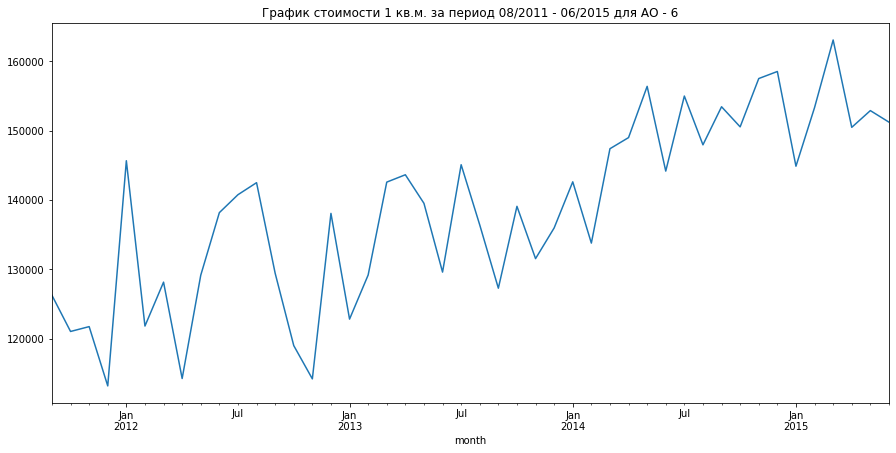

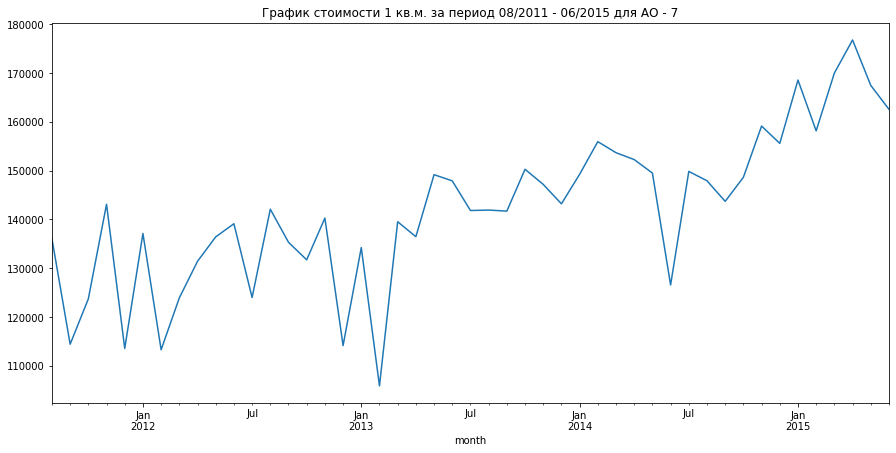

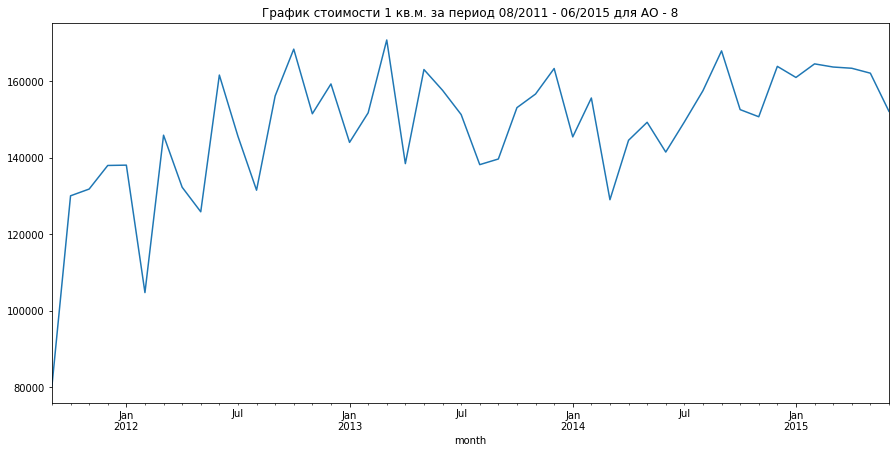

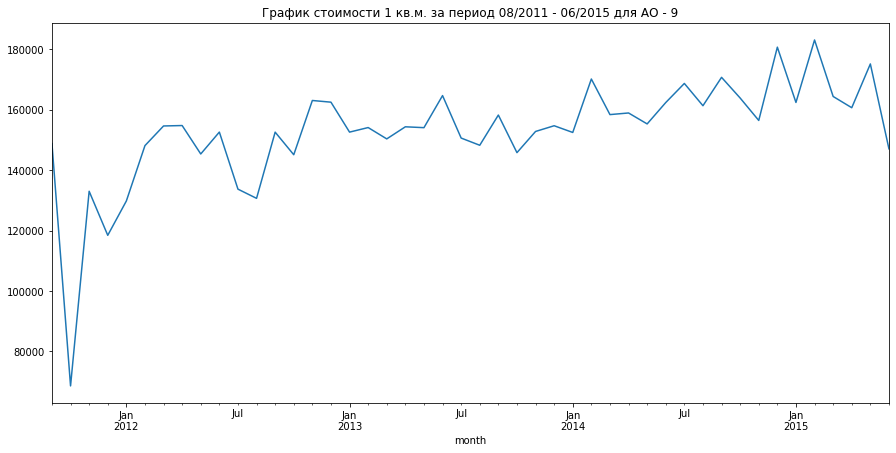

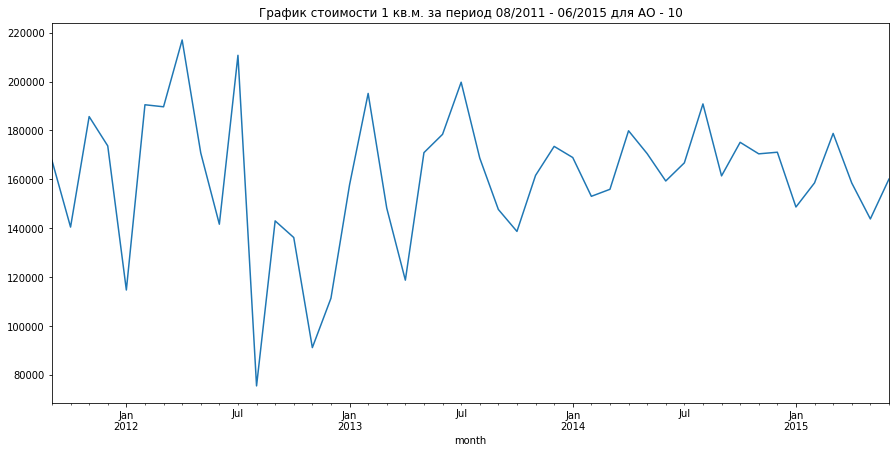

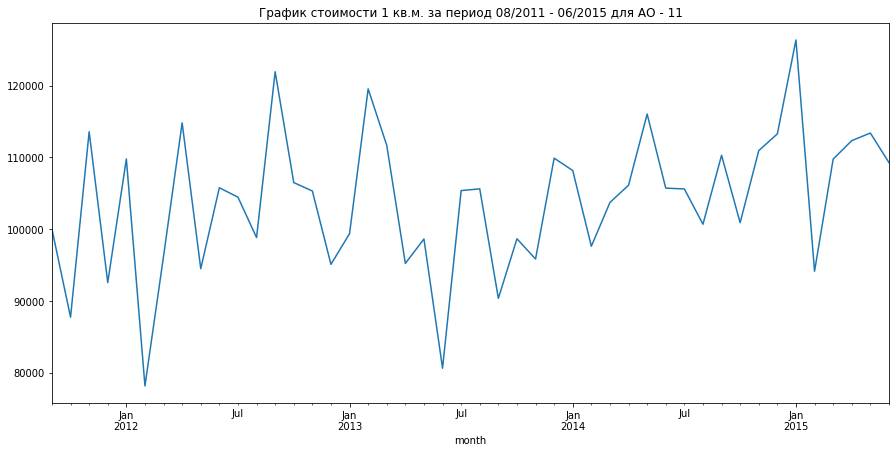

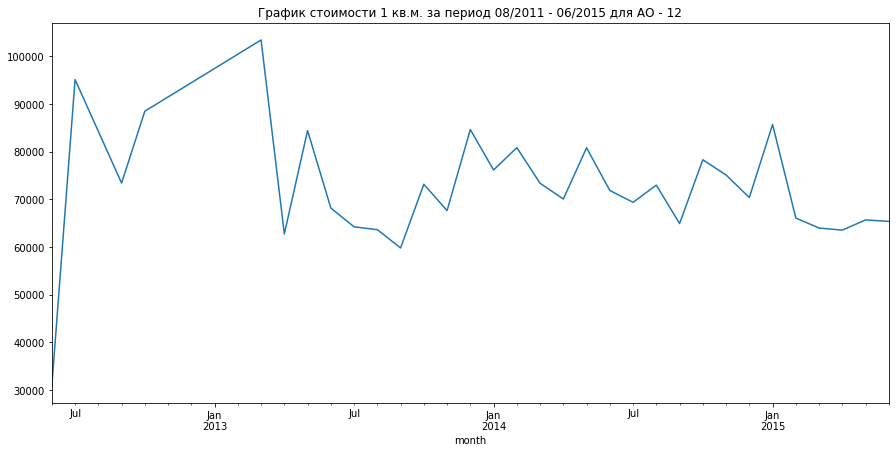

In [ ]:
for number_area in range(1, 13):
  grafik_price(number_area)

df['price_per_sq_const'] = df['price_per_sq'] / df['price_index']

In [ ]:
def grafik_price_infl(number_area):
  okrug = df[(df['area'] == number_area)]
  price_per_sq_okrug_m = okrug.groupby('month')['price_per_sq_const'].mean()

  plt.figure(figsize=(15,7))
  price_per_sq_okrug_m.plot()
  plt.title(f'График стоимости 1 кв.м. за период 08/2011 - 06/2015 для АО - {number_area}, средняя цена по АО - {round(price_per_sq_okrug_m.mean(), 0)}')

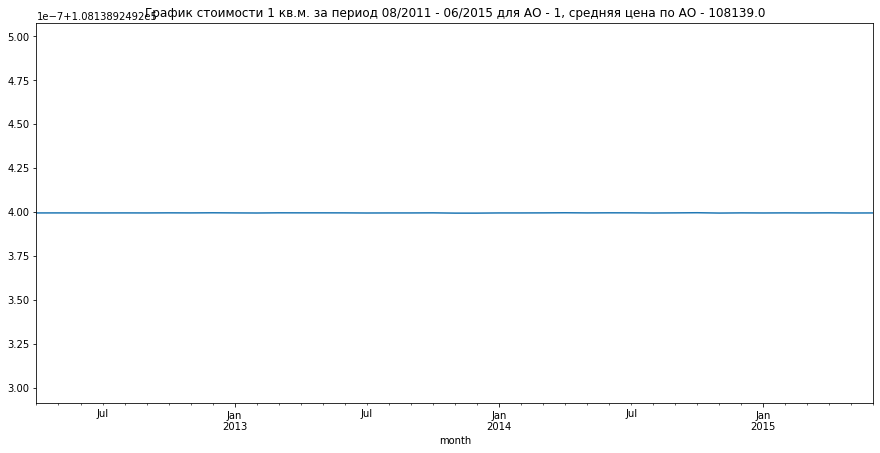

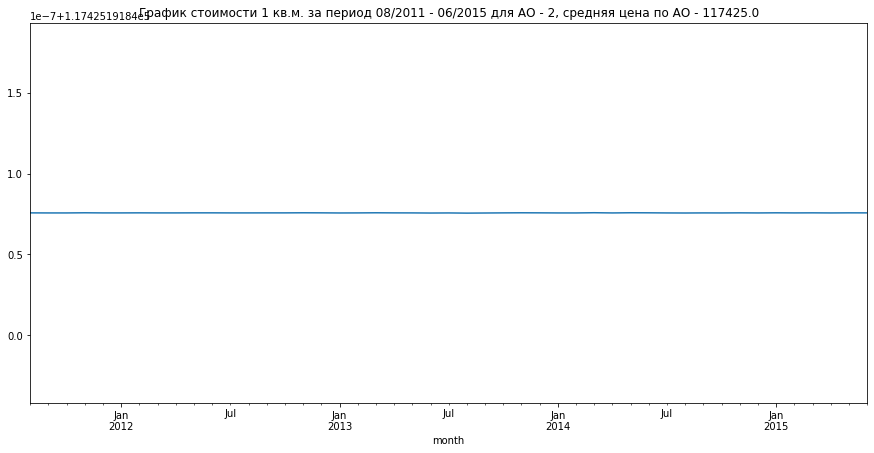

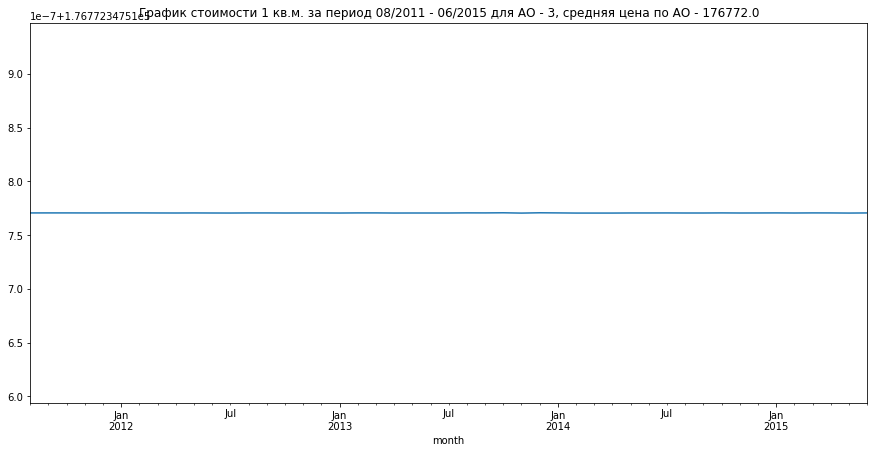

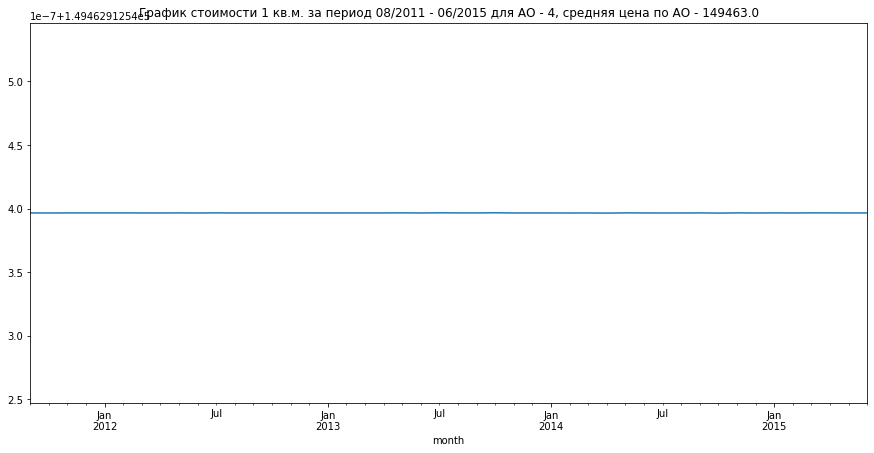

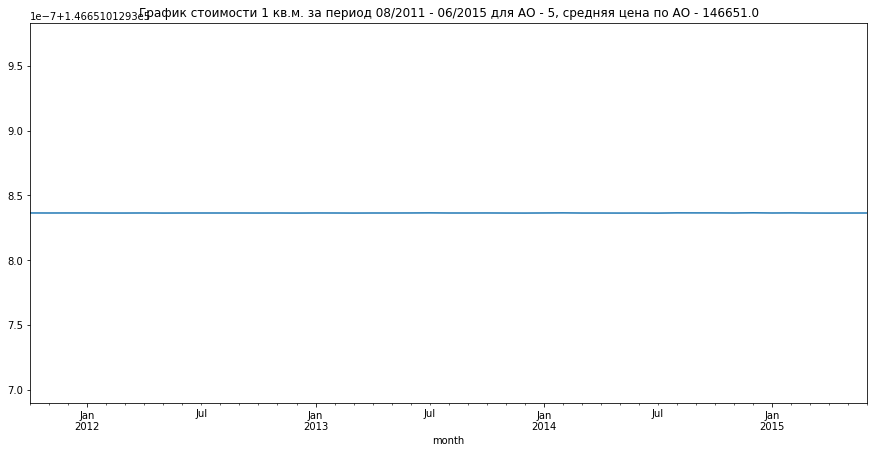

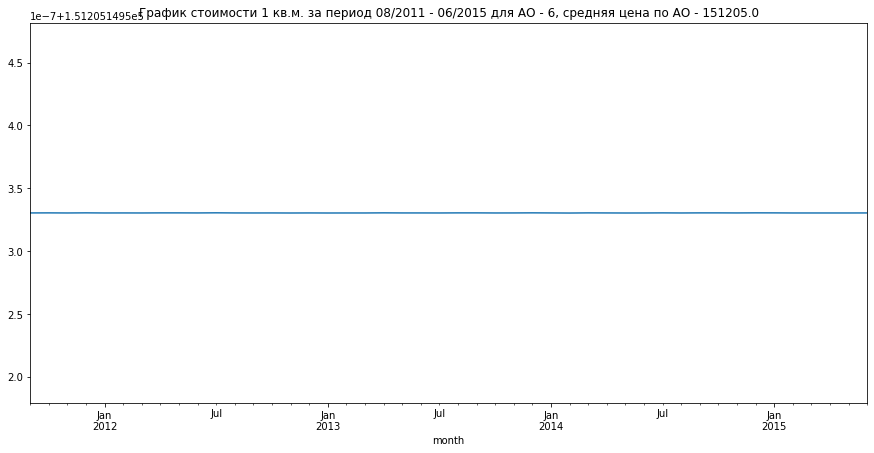

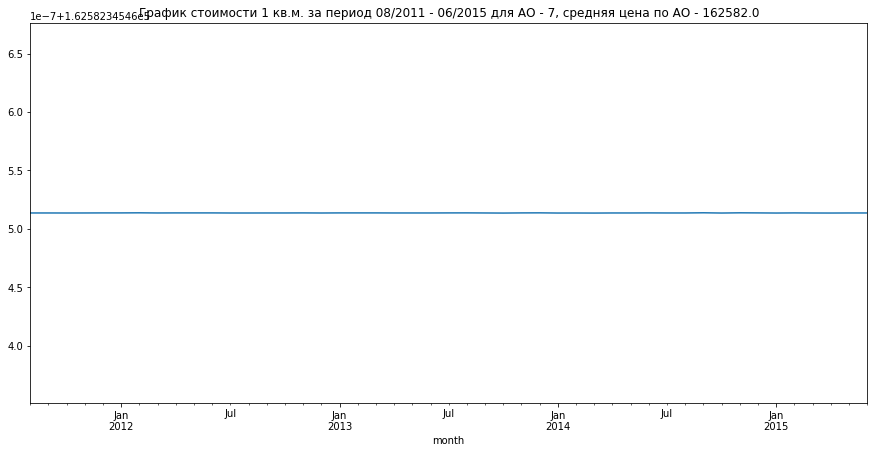

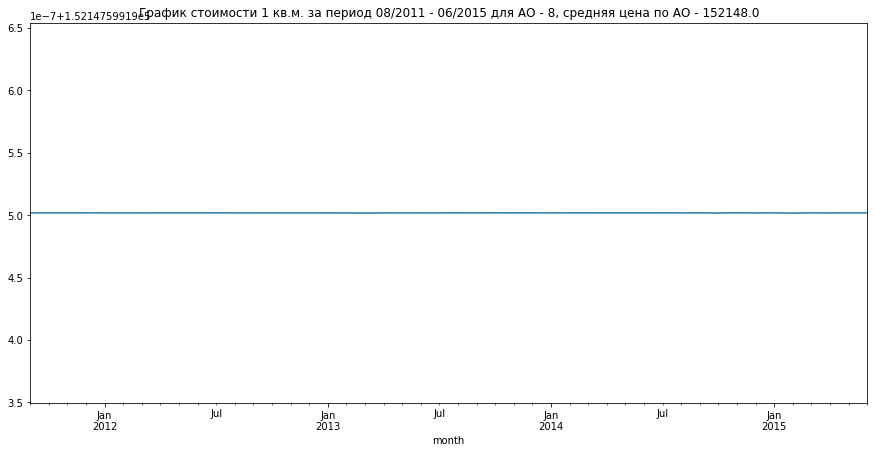

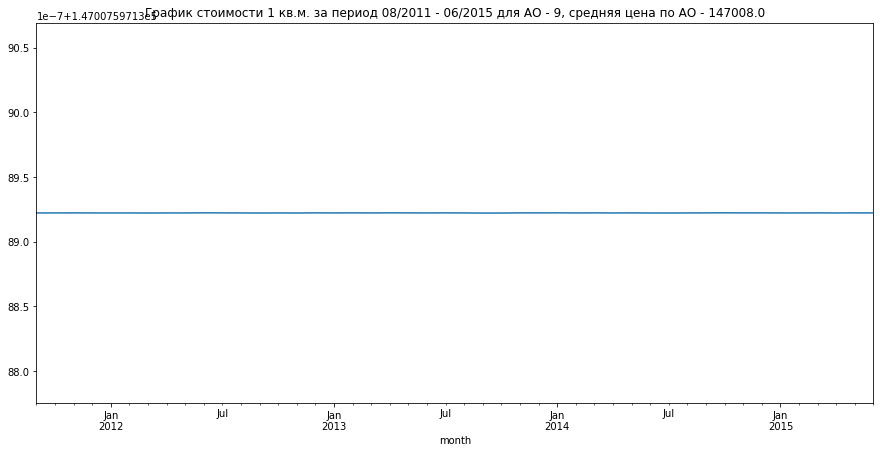

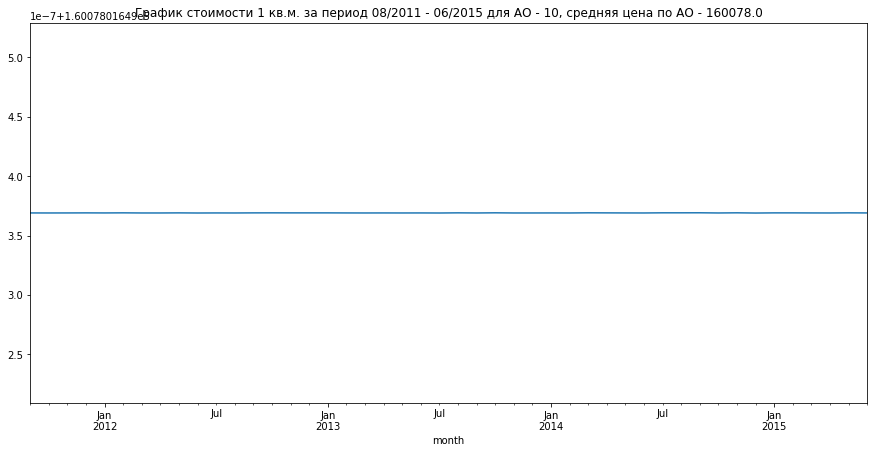

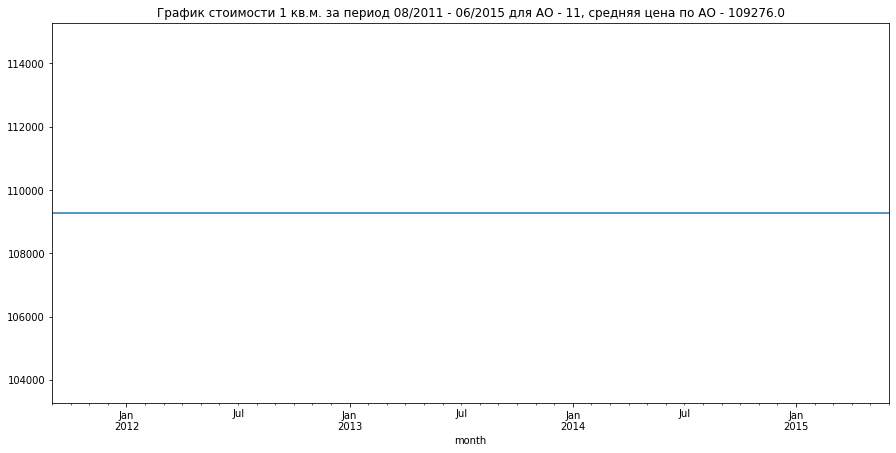

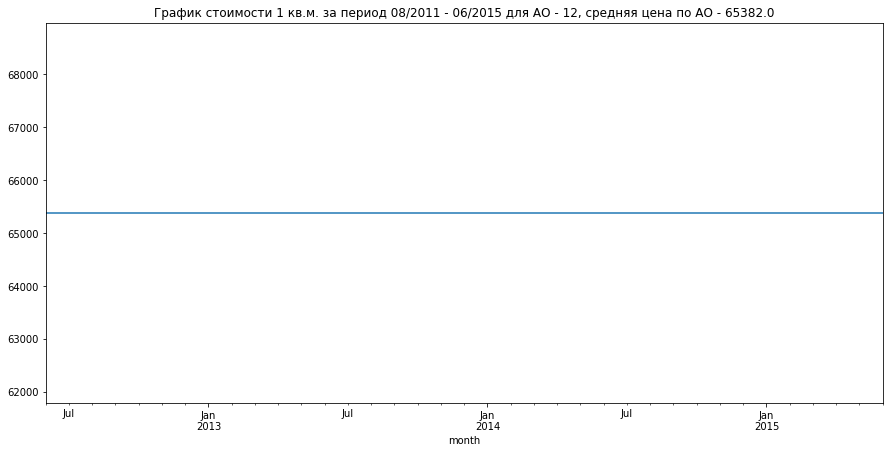

In [ ]:
for number_area in range(1, 13):
  grafik_price_infl(number_area)

In [ ]:
def grafik_target(number_area):
  df['target'] = np.log1p(df['price_per_sq_const'])
  df['extr'] = np.expm1(df['target'])
  okrug = df[(df['area'] == number_area)]

  plt.figure(figsize=(15,7))
  plt.subplot(2,2,1)
  okrug['price_per_sq_const'].hist(bins = 100)
  plt.title(f'График стоимости 1 кв.м. за период 08/2011 - 06/2015 для АО - {number_area}')
  plt.subplot(2,2,2)
  okrug['target'].hist(bins = 100)
  plt.title(f'График логарифма стоимости 1 кв.м. за период 08/2011 - 06/2015 для АО - {number_area}')

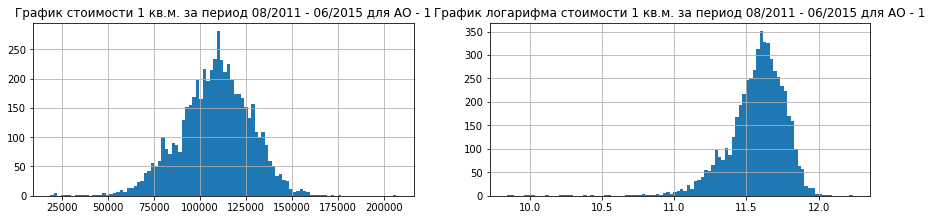

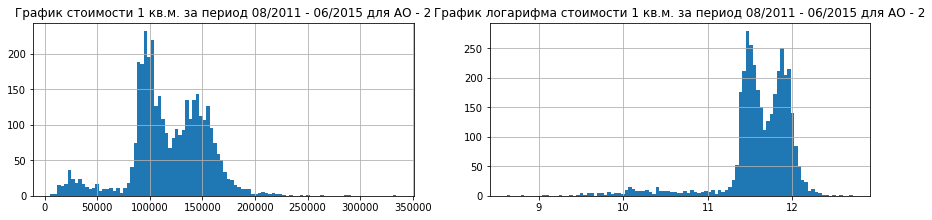

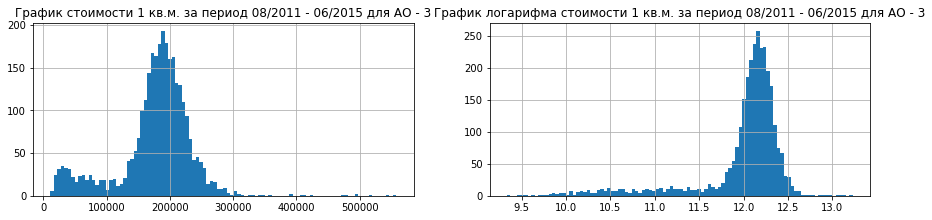

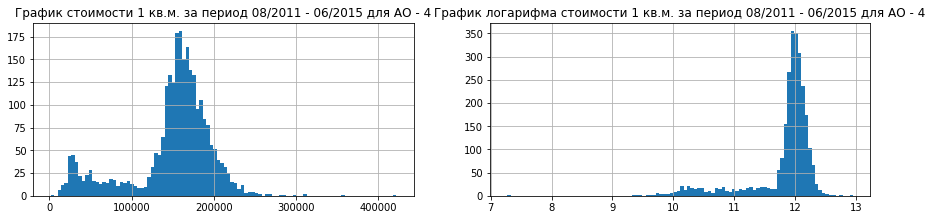

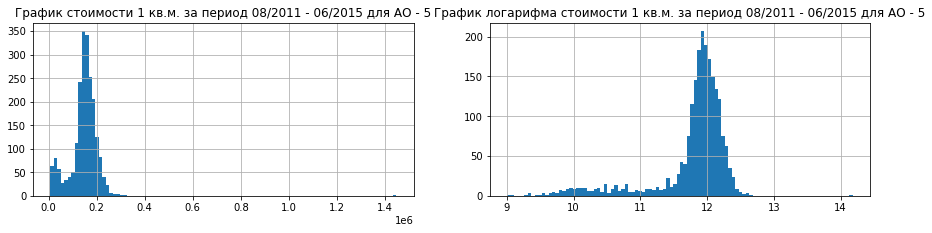

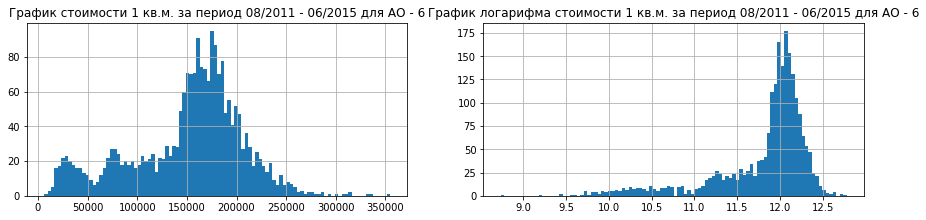

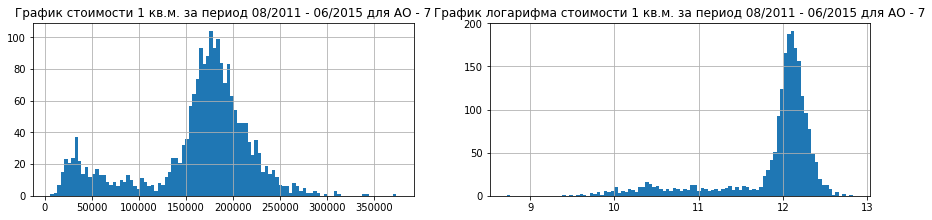

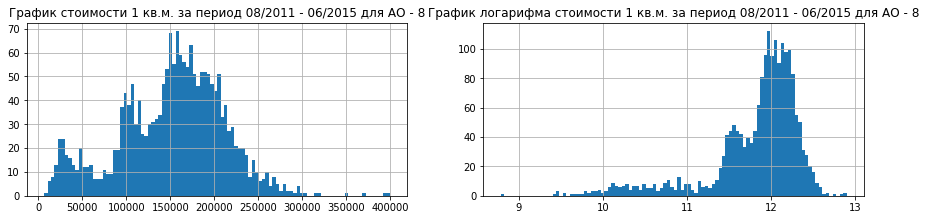

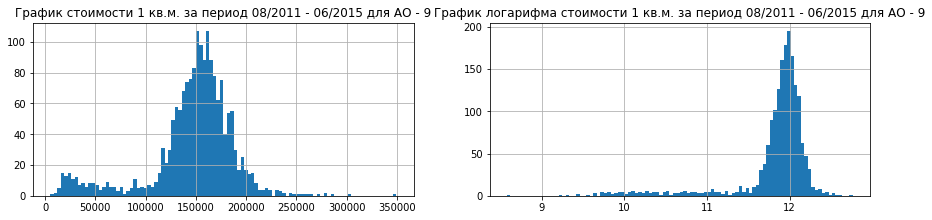

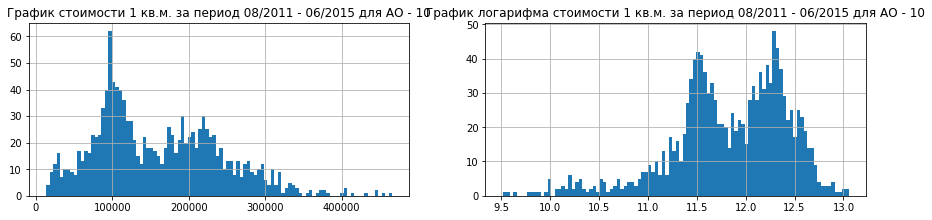

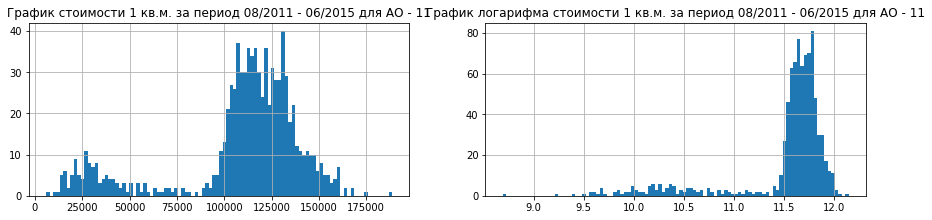

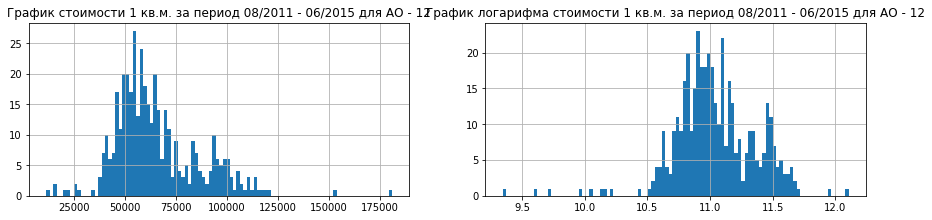

In [ ]:
for number_area in range(1, 13):
  grafik_target(number_area)

Вывод: исходя из полученных графиков видно, что место расположение квартиры влияет на стоимость жилья.
Решила далее проверить данную теорию при помощи матрицы корреляции

In [ ]:
df1 = df[['target', 'area', 'price_doc']]
df1

,target,area,price_doc
0,11.998946,7,5850000
1,12.082624,3,6000000
2,11.673565,2,5700000
7,11.075672,7,2000000
8,11.925903,6,5300000
...,...,...,...
30466,12.032807,7,7400000
30467,12.580043,10,25000000
30468,11.950607,1,6970959
30469,12.259322,5,13500000


In [ ]:
def correlation(l_df):
  df_cor = l_df
  correlation = df_cor.corr()

  plt.figure(figsize = (5,5))
  sns.heatmap(correlation, cmap = 'YlGnBu', annot = True)
  plt.title('Корреляционная матрица')
  plt.show()

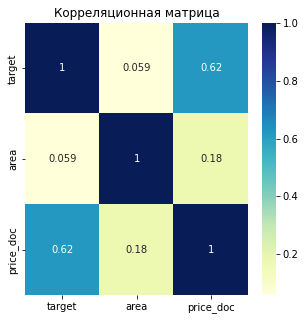

In [ ]:
correlation(df1)

Вывод: зависимость между округом располжения квартиры и стоимостью за 1 квадратный метр - незначительная (хотя в моем понимании корреляция должна быть сильнее). Однако, не исключаю, что где-то ошиблась.

Но в тоже время более сильную корреляцию оказывает месторасположение квартиры на ее стоимость в целом.

##### 2.9 Обработка столбца 'build_year'

Если в объявлении год постройки не указан - объявление исключается из датафрейма. Т.к. "восстановить" данную информацию невозможно.
Или можно попробовать поискать аналогичные по квадратуре и количеству комнат и району квартиры, но на мой взгляд данный подход трудозатратен и малоэффективен (т.к. разброс по дате постройки дома может быть большим. Поскольку многие дома строились сериями на протяжении нескольких лет. Либо были точетной/единичной застройкой).

In [ ]:
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])
print('Количество строк в пустым значением года постройки (NaN) - ', df['build_year'].isna().sum())
print('Количество строк в заполненным значением года постройки - ', df['build_year'].count())

Общее количество оставшихся строк в датафрейме -  27494
Количество строк в пустым значением года постройки (NaN) -  11219
Количество строк в заполненным значением года постройки -  16275


In [ ]:
# Скорее всего годы - 0, 1, 3, 20, 71, 215, 4965, 20052009: это опечатки, произвожу замену некорректных годов постройки

build_year_replace = {0:2000, 1:2001, 3:2003, 20:2020, 71:1971, 215:2015, 4965:1965, 20052009:2009}
df['build_year'].replace(build_year_replace, inplace = True)

In [ ]:
# Так как удалять больше 10 тыс.строк жалко - для всех квартир без года постройки устанавливаю медиану относительно остальных годов построек

print(round(df['build_year'].mean(), 0))
print(df['build_year'].median())

1986.0
1983.0


In [ ]:
df['build_year'] = np.where(df['build_year'].isna(), df['build_year'].median(), df['build_year'])

print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])

Общее количество оставшихся строк в датафрейме -  27494


In [ ]:
# Удаляю строки с пустым годом застройки

df.dropna(subset=['build_year'],inplace=True)
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])

df['build_year'] = df['build_year'].astype(int)

Общее количество оставшихся строк в датафрейме -  27494


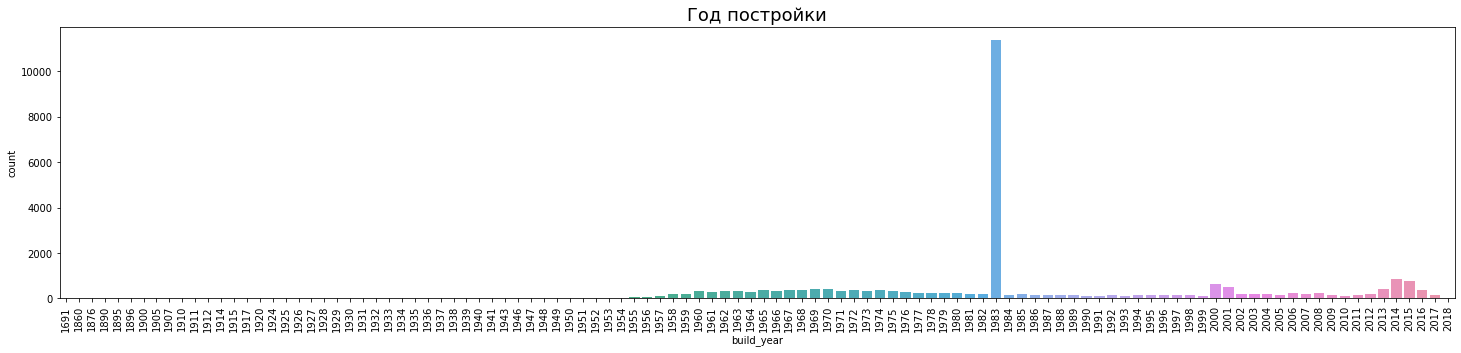

In [ ]:
# Проверяю годы строительства

fig, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x='build_year',data=df)
plt.title('Год постройки', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

После манипуляций с заменой данных в пустых ячейках, "выросло" количество записей с одним годом постройки. Но так как большая часть этих данных далее подвергнется исключению - пренебрегаю данным фактром (и понимаю, что не смогу проверить зависимость стоимости кв.м. от года постройки дома)

##### 2.10 Обработка столбца 'max_floor'

Если в объявлении этажность постройки не указана или равна нулю - объявление исключается из датафрейма. Т.к. "восстановить" данную информацию невозможно.

In [ ]:
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])
print('Количество строк в пустым значением этажности постройки (NaN) - ', df['max_floor'].isna().sum())
print('Количество строк в заполненным значением этажности постройки - ', df['max_floor'].count())

Общее количество оставшихся строк в датафрейме -  27494
Количество строк в пустым значением этажности постройки (NaN) -  7328
Количество строк в заполненным значением этажности постройки -  20166


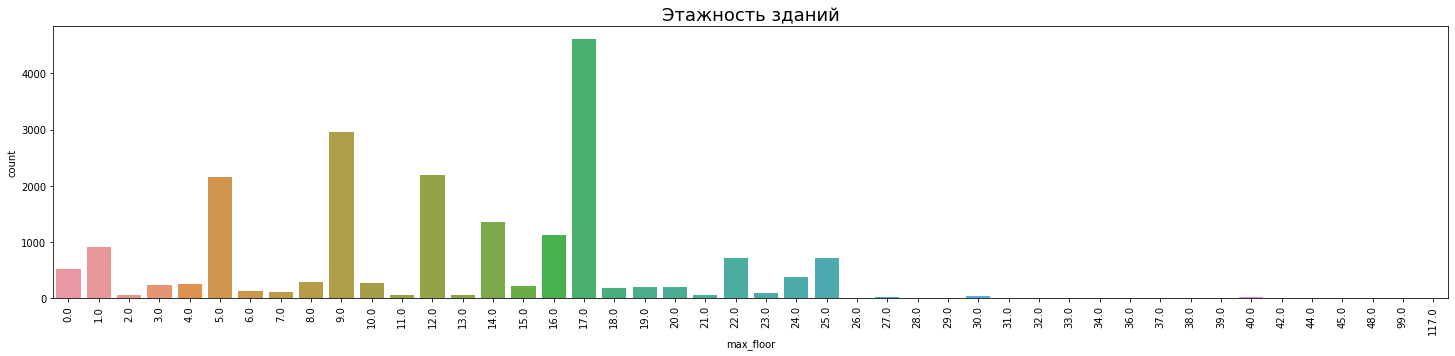

In [ ]:
# Проверяю этажность зданий

fig, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x='max_floor',data=df)
plt.title('Этажность зданий', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# Удаляю строки с нулевой этажностью застройки

print('Количество строк в нулевой этажностью постройки - ', (df['max_floor'] == 0).sum())
df = df.drop(df[df['max_floor'] == 0].index)
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])

Количество строк в нулевой этажностью постройки -  517
Общее количество оставшихся строк в датафрейме -  26977


##### 2.11 Обработка столбца 'floor'

Если отсутствует этаж квартиры в объявлении или равен 0 - пробую заменить средним этажом дома (исходя из этажности дома). Имеется риск, что это повлияет на стоимость кв.метра, т.к. первый и последний этажи дешевле. Но я принебрегу данным фактом (т.к. таких квартир меньше 1%).

In [ ]:
print('Общее количество строк в датафрейме - ', df.shape[0])
print('Количество строк в пустым значением этажа квартиры (NaN) - ', df['floor'].isna().sum())
print('Количество строк в заполненным значением этажа квартиры - ', df['floor'].count())
print('Количество строк в нулевым этажом квартиры - ', (df['floor'] == 0).sum())

Общее количество строк в датафрейме -  26977
Количество строк в пустым значением этажа квартиры (NaN) -  101
Количество строк в заполненным значением этажа квартиры -  26876
Количество строк в нулевым этажом квартиры -  1


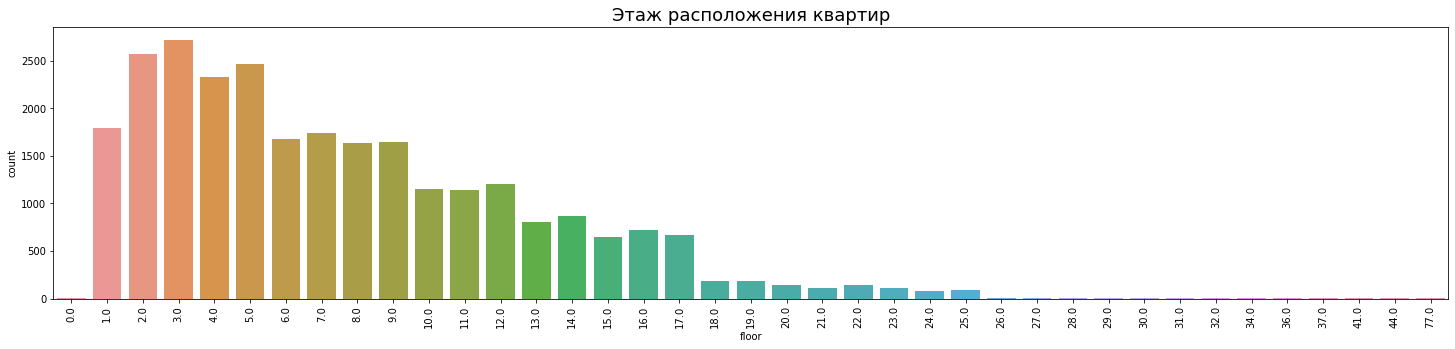

In [ ]:
# Проверяю этаж расположения квартир

fig, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x='floor',data=df)
plt.title('Этаж расположения квартир', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# Проверяю, что этаж квартиры не выше этажности дома

df['check_floor'] = df['floor'] > df['max_floor']
check_floor = df['check_floor'].sum()
print("Количество объявлений, в которых этаж расположения квартиры больше этажности дома - ", check_floor)

Количество объявлений, в которых этаж расположения квартиры больше этажности дома -  911


In [ ]:
# Исправляю этаж квартиры (если он равен нулю или больше этажности дома) на средний этаж дома

df['floor'] = np.where(df['floor'] == 0, (df['max_floor'] // 2) + 1, df['floor'])
df['floor'] = np.where(df['floor'] > df['max_floor'], (df['max_floor'] // 2) + 1, df['floor'])

In [ ]:
# Проверка исправления

df['check_floor'] = df['floor'] > df['max_floor']
check_floor = df['check_floor'].sum()
print("Количество объявлений, в которых этаж расположения квартиры больше этажности дома - ", check_floor)
print('Количество строк в нулевым этажом квартиры - ', (df['floor'] == 0).sum())

df = df.drop('check_floor', axis=1)

Количество объявлений, в которых этаж расположения квартиры больше этажности дома -  0
Количество строк в нулевым этажом квартиры -  0


In [ ]:
# Проверка на наличие дробных этажей

df['floor'].unique()

array([ 4.,  3.,  2.,  5.,  9., 12., 11., 15., 10.,  7.,  6.,  1., 24.,
       16.,  8., 13., 14., 18., nan, 20., 23., 19., 17., 22., 25., 29.,
       21., 30., 27., 32., 37., 26., 28., 36., 41., 31., 34., 44.])

In [ ]:
print('Общее количество оставшихся строк в датафрейме - ', df.shape[0])

Общее количество оставшихся строк в датафрейме -  26977


##### После проведения корректировок данных - решила обучить модель. И посмотреть насколько ухудшилось/улучшилось качество в сравнении с тем, что было получено на лекции

In [ ]:
df = df.drop(['sub_area_new', 'dow', 'dom', 'doy', 'month', 'woy', 'price_per_sq', 'date', 'price_per_sq_const', 'extr', 'price_doc'], axis=1)
df.shape

(26977, 378)

In [ ]:
def learning(l_df):

  # Перемешиваем наблюдения
  df = shuffle(l_df)

  # бейзлайн
  X_new = df.copy()
  X_new = X_new[X_new.select_dtypes(include = 'number').columns]

  X_new = X_new.dropna()
  y_new = X_new.pop('target')

  from sklearn.model_selection import train_test_split as tts
  X_train0, X_test0, y_train0, y_test0 = tts(X_new, y_new, test_size = 0.2, shuffle = True, random_state = 42)
  pr_index_train = X_train0.pop('price_index')
  pr_index_test = X_test0.pop('price_index')

  print('Строк/столбцов для обучения', X_train0.shape)
  print('Строк/столбцов для тестирования', X_test0.shape)

  from sklearn.ensemble import GradientBoostingRegressor

  reg0 = GradientBoostingRegressor(random_state=0)
  reg0.fit(X_train0, y_train0)

  y_train_pred0 = reg0.predict(X_train0)
  y_test_pred0 = reg0.predict(X_test0)

  def train_transf(target):
    return np.expm1(target) * pr_index_train

  def test_transf(target):
    return np.expm1(target) * pr_index_test

  from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

  print('Train RMSLE', np.sqrt(mse(y_train0, y_train_pred0)), ' ', 'Test RMSLE', np.sqrt(mse(y_test0, y_test_pred0)))
  print('Train MAE', mae(train_transf(y_train0), train_transf(y_train_pred0)), ' ', 'Test MAE', mae(test_transf(y_test0), test_transf(y_test_pred0)))
  print('Ошибка', mae(test_transf(y_test0), test_transf(y_test_pred0)) / test_transf(y_test0).mean())

In [ ]:
learning(df)

Строк/столбцов для обучения (4024, 375)
Строк/столбцов для тестирования (1007, 375)
Train RMSLE 0.47395286196573255   Test RMSLE 0.5736103084837574
Train MAE 37257.774570351496   Test MAE 45124.89063664235
Ошибка 0.28455079629938357


Справочно! В лекции были получены следующие результаты:

Train RMSLE 0.476874; Test RMSLE 0.577699

Train MAE 37550; Test MAE 46227

Ошибка 0.292834

Модель все также переучена. Значение ошибки снизилось приблизительно на 1%. Для дальнейшего обучения модели решила исключить из выборки признаки с незначительной корреляцией на стоимость 1 кв.м. (Исключала не просматривая и "прикидывая" какой из признаков оказывает большее влияние - а фильтруя по значению полученного коэффициента)

##### 2.12 Удаление бесполезных признаков.

In [ ]:
df2_cor = df
correlation = df2_cor.corr()
correlation.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,...,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm,area,price_index,target
full_sq,1.000000,0.948747,0.113740,0.168926,-0.029457,0.225383,0.759275,0.728483,-0.097686,0.175643,0.065926,-0.083372,0.044114,-0.060883,-0.053700,0.019209,-0.037754,-0.055354,0.054052,-0.047170,0.015668,-0.057150,-0.038711,0.033577,0.005165,0.019813,0.040854,0.044637,0.012994,0.039736,-0.031231,0.029369,-0.030251,-0.077951,0.036341,0.008811,-0.019905,-0.004334,-0.024734,-0.024126,...,-0.011776,-8.642622e-02,-8.642622e-02,-0.049809,-0.203790,-1.120036e-01,0.167262,-8.642622e-02,8.642622e-02,0.214361,-0.167048,-0.134536,-0.205299,0.123922,0.162813,0.161458,0.091962,0.189678,0.079007,0.059933,0.139153,0.190569,-0.106857,0.126863,-0.067199,-0.188128,-0.183399,-0.150734,-0.190174,-0.206863,-0.205830,0.217423,0.062662,0.214668,0.206181,0.135457,0.020689,0.019553,0.116906,-0.100623
life_sq,0.948747,1.000000,0.050537,0.070050,-0.037110,0.098691,0.817763,0.574788,-0.084842,0.156131,0.045233,-0.067982,0.037936,-0.046218,-0.056268,-0.025742,-0.037639,-0.053817,0.009643,-0.040299,0.019700,-0.024925,-0.018951,0.039007,0.018491,0.012396,0.048660,0.045373,0.018184,0.049604,-0.016156,0.017846,-0.016114,-0.051149,0.040294,0.004444,-0.018019,-0.010511,-0.023595,-0.023022,...,-0.013481,-8.545958e-02,-8.545958e-02,-0.049042,-0.207268,-1.121272e-01,0.168933,-8.545958e-02,8.545958e-02,0.216843,-0.167837,-0.137616,-0.206530,0.120796,0.159553,0.159893,0.094417,0.188673,0.077964,0.061508,0.136640,0.187013,-0.107343,0.120628,-0.063240,-0.188114,-0.179816,-0.145751,-0.190272,-0.209060,-0.207270,0.217453,0.055579,0.213623,0.210017,0.137023,0.012592,0.022884,0.110353,-0.088094
floor,0.113740,0.050537,1.000000,0.608764,0.004256,0.242628,0.012232,0.189944,-0.061272,0.153597,-0.010565,-0.044453,0.014209,-0.011113,-0.010836,0.056009,0.006198,-0.015835,0.077805,-0.016035,-0.017860,-0.105208,-0.071448,-0.005360,-0.039063,0.047159,0.011239,0.018684,0.013123,-0.015671,-0.051441,0.103266,-0.036558,-0.086696,-0.003509,0.004782,-0.016753,0.014714,-0.020121,-0.020406,...,0.048130,-3.248016e-02,-3.248016e-02,-0.040715,0.029603,-2.814368e-02,-0.046449,-3.248016e-02,3.248016e-02,-0.023162,0.045795,0.049385,0.024105,-0.022176,-0.009027,-0.019390,-0.034497,-0.012789,-0.000826,-0.023517,-0.040602,-0.020855,0.039299,-0.023910,-0.006383,0.035136,0.024325,0.026702,0.007031,0.027792,0.025560,-0.014350,-0.019301,-0.022738,-0.020352,0.023070,-0.006496,-0.074704,-0.008372,0.018361
max_floor,0.168926,0.070050,0.608764,1.000000,0.021240,0.448075,-0.034339,0.357254,-0.095026,0.172764,-0.016974,-0.075

In [ ]:
tmp = correlation['target'].sort_values()
tmpWhere = tmp[abs(tmp) >= 0.2]
tmpWhere

zd_vokzaly_avto_km           -0.316320
ttk_km                       -0.304023
sadovoe_km                   -0.303322
basketball_km                -0.296255
bulvar_ring_km               -0.295897
kremlin_km                   -0.294345
nuclear_reactor_km           -0.293051
stadium_km                   -0.283406
workplaces_km                -0.280185
thermal_power_plant_km       -0.273414
swim_pool_km                 -0.272536
public_healthcare_km         -0.270679
big_church_km                -0.270335
university_km                -0.264448
catering_km                  -0.263863
exhibition_km                -0.262595
detention_facility_km        -0.257811
metro_min_walk               -0.256274
metro_km_walk                -0.256274
metro_km_avto                -0.256241
radiation_km                 -0.255002
office_km                    -0.253530
power_transmission_line_km   -0.253372
fitness_km                   -0.253115
metro_min_avto               -0.251177
ts_km                    

In [ ]:
len(tmpWhere)

44

In [ ]:
lis = tmpWhere.index
lis

Index(['zd_vokzaly_avto_km', 'ttk_km', 'sadovoe_km', 'basketball_km',
       'bulvar_ring_km', 'kremlin_km', 'nuclear_reactor_km', 'stadium_km',
       'workplaces_km', 'thermal_power_plant_km', 'swim_pool_km',
       'public_healthcare_km', 'big_church_km', 'university_km', 'catering_km',
       'exhibition_km', 'detention_facility_km', 'metro_min_walk',
       'metro_km_walk', 'metro_km_avto', 'radiation_km', 'office_km',
       'power_transmission_line_km', 'fitness_km', 'metro_min_avto', 'ts_km',
       'park_km', 'museum_km', 'theater_km', 'shopping_centers_km',
       'school_km', 'preschool_km', 'area_m', 'mosque_km',
       'bus_terminal_avto_km', 'kindergarten_km', 'trc_sqm_3000',
       'sport_count_2000', 'sport_count_3000', 'market_count_5000',
       'sport_count_5000', 'trc_count_5000', 'trc_sqm_5000', 'target'],
      dtype='object')

In [ ]:
# 'price_index' и 'area' оставляю намеренно, т.к. все еще надеюсь на то, что нужны для обучения

for elem in df2_cor:
  if elem in lis or elem == 'price_index' or elem == 'area':
    continue
  else:
    df2_cor = df2_cor.drop(elem, axis = 1)

In [ ]:
learning(df2_cor)

Строк/столбцов для обучения (21564, 44)
Строк/столбцов для тестирования (5392, 44)
Train RMSLE 0.4515393373884779   Test RMSLE 0.4708112152693734
Train MAE 31015.607246769712   Test MAE 31912.955580087306
Ошибка 0.24059491506702202


Из результатов видно, что уменьшение количества бесполезных признаков благоприятно влияет на обучение модели: увеличилось количество строк для обучения и тестирования модели (в несколько раз), модель получилась не переученной и общая ошибка снизилась на 4%.

##### 6. Реализовать методы feature engineering с целью повышения метрик качества модели. 

Feature engineering так и осталось для меня "темным лесом". Поэтому я оставила тот же код, что Вы показывали на лекции по разбору курсовой работы.

Проверяла несколько вариантов:
- датафрейм без удаления большого количества признаков
- датафрейм с удалением большого количества признаков (с незначительной корреляцией)
- датафрейм без удаления большого количества признаков (но с исключением признаков, которые на лекции группировались в категориальный признак)

In [ ]:
df = df.drop(['timestamp'], axis=1)

In [ ]:
def feature_engineering(i_df, cat_features2):

  def train_transf(target):
    return np.expm1(target) * pr_index_train

  def test_transf(target):
    return np.expm1(target) * pr_index_test
  
  X = i_df.copy()
  y = X.pop('target')

  X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, stratify = X['area'], shuffle = True, random_state = 42)
  pr_index_train = X_train.pop('price_index')
  pr_index_test = X_test.pop('price_index')

  cat_features1 = ['area']
  # cat_features2 = ['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion',
  #                'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line',
  #                'railroad_1line', 'product_type', 'ecology', 'material', 'state', 'build_year']
  cat_features = cat_features1 + cat_features2

  sc_features = list(set(X_train.columns.tolist()) - set(cat_features))


  categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')),
                                              ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
  imputer_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent'))])
  scale_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                        ('scaler', MinMaxScaler())])
 
  preprocessor = ColumnTransformer(transformers = [('cat1', categorical_transformer, cat_features1),
                                                  ('cat2', imputer_transformer, cat_features2),
                                                  ('scale', scale_transformer, sc_features)], 
                                  remainder = 'passthrough')

  reg = Pipeline(steps = [('preprocessor', preprocessor),
                          ('regressor', GradientBoostingRegressor(random_state = 5))])

  reg.fit(X_train, y_train)
 
  y_train_pred = reg.predict(X_train)
  y_test_pred = reg.predict(X_test)

  print('Train RMSLE', np.sqrt(mse(y_train, y_train_pred)), ' ', 'Test RMSLE', np.sqrt(mse(y_test, y_test_pred)))
  print('Train MAE', mae(train_transf(y_train), train_transf(y_train_pred)), ' ', 'Test MAE', mae(test_transf(y_test), test_transf(y_test_pred)))

  print(mae(test_transf(y_test), test_transf(y_test_pred)) / test_transf(y_test).mean())

In [ ]:
# Обучение модели на датафрейме без удаления признаков с низким значением корреляции (аналогично лекции)

cat_features2 = ['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion',
                 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line',
                 'railroad_1line', 'product_type', 'ecology', 'material', 'state', 'build_year']
feature_engineering(df, cat_features2)

Train RMSLE 0.4389510441144721   Test RMSLE 0.4524788412108357
Train MAE 29310.921289803624   Test MAE 30572.68476311446
0.2284796516939018


In [ ]:
# Обучение модели на датафрейме без удаления признаков с низким значением корреляции, но с удалением признаков, выделяемых в лекции в отдельный
# категориальный признак

df_bez = df.drop(['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion',
                 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line',
                 'railroad_1line', 'product_type', 'ecology', 'material', 'state', 'build_year'], axis=1)

def train_transf(target):
  return np.expm1(target) * pr_index_train

def test_transf(target):
  return np.expm1(target) * pr_index_test

X = df_bez.copy()
y = X.pop('target')

X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, stratify = X['area'], shuffle = True, random_state = 42)
pr_index_train = X_train.pop('price_index')
pr_index_test = X_test.pop('price_index')

cat_features1 = ['area']
# cat_features2 = ['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion',
#                'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line',
#                'railroad_1line', 'product_type', 'ecology', 'material', 'state', 'build_year']
cat_features = cat_features1 + cat_features2

sc_features = list(set(X_train.columns.tolist()) - set(cat_features))


categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
imputer_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent'))])
scale_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                      ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(transformers = [('cat1', categorical_transformer, cat_features1),
                                                #('cat2', imputer_transformer, cat_features2),
                                                ('scale', scale_transformer, sc_features)], 
                                remainder = 'passthrough')

reg = Pipeline(steps = [('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor(random_state = 5))])

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

print('Train RMSLE', np.sqrt(mse(y_train, y_train_pred)), ' ', 'Test RMSLE', np.sqrt(mse(y_test, y_test_pred)))
print('Train MAE', mae(train_transf(y_train), train_transf(y_train_pred)), ' ', 'Test MAE', mae(test_transf(y_test), test_transf(y_test_pred)))

print(mae(test_transf(y_test), test_transf(y_test_pred)) / test_transf(y_test).mean())

Train RMSLE 0.4406249121399967   Test RMSLE 0.4556389463492783
Train MAE 29585.919198058604   Test MAE 30944.7162890537
0.2312599647126754


In [ ]:
# Обучение модели на датафрейме после удаления признаков с низким значением корреляции

cat_features2 = ['trc_sqm_3000', 'market_count_5000', 'trc_count_5000', 'trc_sqm_5000', 'shopping_centers_km']
feature_engineering(df2_cor, cat_features2)

Train RMSLE 0.45201323503614915   Test RMSLE 0.460390027242677
Train MAE 30919.563240310556   Test MAE 31903.918829764196
0.23842839836852012


In [ ]:
  # Обучение модели на датафрейме после удаления признаков с низким значением корреляции и детальной категоризацией признаков
  
  def train_transf(target):
    return np.expm1(target) * pr_index_train

  def test_transf(target):
    return np.expm1(target) * pr_index_test
  
  X = df2_cor.copy()
  y = X.pop('target')

  X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, stratify = X['area'], shuffle = True, random_state = 42)
  pr_index_train = X_train.pop('price_index')
  pr_index_test = X_test.pop('price_index')

  cat_features1 = ['area']
  cat_features2 = ['zd_vokzaly_avto_km', 'ttk_km', 'sadovoe_km', 'bus_terminal_avto_km']
  cat_features3 = ['basketball_km', 'stadium_km', 'swim_pool_km', 'fitness_km', 'sport_count_2000', 'sport_count_3000', 'sport_count_5000']
  cat_features4 = ['university_km', 'school_km', 'kindergarten_km', 'preschool_km',]
  cat_features5 = ['metro_min_walk', 'metro_km_walk', 'metro_km_avto', 'metro_min_avto']
  cat_features6 = ['trc_sqm_3000', 'market_count_5000', 'trc_count_5000', 'trc_sqm_5000', 'shopping_centers_km']
  cat_features7 = ['park_km', 'museum_km', 'theater_km']
  cat_features = cat_features1 + cat_features2 + cat_features3 + cat_features4 + cat_features5 + cat_features6 + cat_features7

  sc_features = list(set(X_train.columns.tolist()) - set(cat_features))


  categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')),
                                              ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
  imputer_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent'))])
  scale_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                        ('scaler', MinMaxScaler())])
 
  preprocessor = ColumnTransformer(transformers = [('cat1', categorical_transformer, cat_features1),
                                                  ('cat2', imputer_transformer, cat_features2),
                                                   ('cat3', imputer_transformer, cat_features3),
                                                   ('cat4', imputer_transformer, cat_features4),
                                                   ('cat5', imputer_transformer, cat_features5),
                                                   ('cat6', imputer_transformer, cat_features6),
                                                   ('cat7', imputer_transformer, cat_features7),
                                                  ('scale', scale_transformer, sc_features)], 
                                  remainder = 'passthrough')

  reg = Pipeline(steps = [('preprocessor', preprocessor),
                          ('regressor', GradientBoostingRegressor(random_state = 5))])

  reg.fit(X_train, y_train)
 
  y_train_pred = reg.predict(X_train)
  y_test_pred = reg.predict(X_test)

  print('Train RMSLE', np.sqrt(mse(y_train, y_train_pred)), ' ', 'Test RMSLE', np.sqrt(mse(y_test, y_test_pred)))
  print('Train MAE', mae(train_transf(y_train), train_transf(y_train_pred)), ' ', 'Test MAE', mae(test_transf(y_test), test_transf(y_test_pred)))

  print(mae(test_transf(y_test), test_transf(y_test_pred)) / test_transf(y_test).mean())

Train RMSLE 0.4520346741357999   Test RMSLE 0.4610830483110027
Train MAE 30956.22047647759   Test MAE 31934.178323320342
0.23865453744010348


Мои выводы по курсовой работе:
1. Наилучший результат обучения показала модель с кодом показанным в лекции. Могу сделать вывод, что все мои манипуляции с восстановлением данных были излишни (и нужно было обрабатывать данные как-то иначе).
2. Объединение нескольких признаков в один общий незначительно влияют на качество обучения (снижение ошибки приблизительно на 1%). При общей ошибке 22~23% - это капля в море и, на мой взгляд, не стоит с ней заморачиваться.
3. Для повышения качества обучения модели необходимо увеличивать выборку данных (в отношении количества записейб а не количества признаков)  